# NONCOVToolbox: Step 3

## Plot the data from the dataset and do explorative data analysis

### Load necessary modules from the NONCOVToolbox src

In [1]:
# Get the NONCOVToolbox library and print header
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.cluster import KMeans
import pathlib as Path
import seaborn as sns
import re
import seaborn as sns

path_noncov = os.path.abspath(os.path.join('..', 'src'))

if path_noncov not in sys.path:
    sys.path.append(path_noncov)

from noncov import NONCOVToolbox, NONCOVHeader

noncov = NONCOVToolbox()

#NONCOVHeader.print_header()

# Pre work on molecular geometries
from noncov import StructureModifier

# OrcaAnalysis module for postprocessing of DFT calculations
from noncov import OrcaAnalysis

# Graph molecular representations
from noncov import MolecularGraph

# Functions to store data in dataframes
from noncov import MachineLearning

# Show performance and features of various NMR functions in module
from noncov import NMRFunctions

# Display the molecule while its displaced, not yet interactive in Jupyter but interactive in VS Code
from noncov import MolView

# Disable printing
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore printing
def enablePrint():
    sys.stdout = sys.__stdout__

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Get work directory and scratch folder for the output data
current_dir = os.getcwd()
print(f'Current work directory is: {current_dir}')

scratch_dir = os.path.abspath(os.path.join('..', 'scratch'))
print(f'Current scratch directory is: {scratch_dir}')
scratch_dir = OrcaAnalysis().convert_path(scratch_dir)

Current work directory is: /Users/ettorebartalucci/Desktop/NONCOV/results
Current scratch directory is: /Users/ettorebartalucci/Desktop/NONCOV/scratch
Normalized path using os.path: /Users/ettorebartalucci/Desktop/NONCOV/scratch


### Show dataset

In [5]:
datasets_dir = os.path.join(scratch_dir, 'GenerateMLDataset/data/')
print(f'Dataset directory is: {datasets_dir}')
datasets_dir = OrcaAnalysis().convert_path(datasets_dir)

dataset_name = 'fragments_hopt_nmr.csv'

nucprop = os.path.join(datasets_dir, dataset_name)
nucprop_df = pd.read_csv(nucprop)

Dataset directory is: /Users/ettorebartalucci/Desktop/NONCOV/scratch/GenerateMLDataset/data/
Normalized path using os.path: /Users/ettorebartalucci/Desktop/NONCOV/scratch/GenerateMLDataset/data/


In [7]:
# Individual nuclear properties
nucprop_df.head()

,Molecule,Atom,x_coord,y_coord,z_coord,sigma_iso,sigma_xx,sigma_yy,sigma_zz,dia_sigma_xx,...,dia_sigma_zz,para_sigma_xx,para_sigma_yy,para_sigma_zz,sigma_11,sigma_22,sigma_33,s_tot_symmetry,span,skew
0,df_cut_4_n1_opt.xyz,Nucleus 7H :,1.004732,0.618235,0.399603,28.71,34.44,26.20,25.50,45.09,...,20.37,-12.17,3.32,5.17,25.50,26.20,34.44,0,8.94,-0.84
1,df_cut_4_n1_opt.xyz,Nucleus 8H :,-0.479139,0.823720,0.426466,28.66,33.20,27.90,24.88,24.68,...,34.50,-8.86,-2.88,2.09,24.88,27.90,33.20,0,8.32,-0.27
2,df_cut_4_n1_opt.xyz,Nucleus 9H :,-1.139424,1.293590,-0.715278,25.80,29.45,26.15,21.81,45.32,...,30.01,-19.56,0.18,-7.79,21.81,26.15,29.45,0,7.64,0.14
3,df_cut_4_n1_opt.xyz,Nucleus 10H :,-2.529680,1.410024,-0.731269,25.71,21.87,27.98,27.28,45.53,...,18.25,-18.92,-4.64,4.48,21.87,27.28,27.98,0,6.11,0.77
4,df_cut_4_n1_opt.xyz,Nucleus 11H :,-3.272787,1.055261,0.391918,23.23,22.20,23.28,24.21,12.13,...,40.98,10.96,-20.55,-16.79,22.20,23.28,24.21,0,2.01,0.07


## Feature selection before ML

We now want to select the features that will be most important for our Machine Learning application.

For Supervised Learning, in our dataset we have 20 features, and maybe we dont need all of them but only some. We can do feature selection in few ways:

* Correlation Matrix Plot
* Univariate Testing
* Recursive Feature Elimination with Cross Validation

### Correlation Matrix plot

From *Medium* Website: A correlation matrix is simply a table which displays the correlation coefficients for different variables. The matrix depicts the correlation between all the possible pairs of values in a table. It is a powerful tool to summarize a large dataset and to identify and visualize patterns in the given data.

A correlation matrix consists of rows and columns that show the variables. Each cell in a table contains the correlation coefficient.

In [9]:
# Do not work directly on the real data
df = nucprop_df

# Remove S_tot symmetry since its always zero - this needs to be checked, seems fishy
df = df.drop(columns='s_tot_symmetry')

df

,Molecule,Atom,x_coord,y_coord,z_coord,sigma_iso,sigma_xx,sigma_yy,sigma_zz,dia_sigma_xx,dia_sigma_yy,dia_sigma_zz,para_sigma_xx,para_sigma_yy,para_sigma_zz,sigma_11,sigma_22,sigma_33,span,skew
0,df_cut_4_n1_opt.xyz,Nucleus 7H :,1.004732,0.618235,0.399603,28.71,34.44,26.20,25.50,45.09,24.36,20.37,-12.17,3.32,5.17,25.50,26.20,34.44,8.94,-0.84
1,df_cut_4_n1_opt.xyz,Nucleus 8H :,-0.479139,0.823720,0.426466,28.66,33.20,27.90,24.88,24.68,36.46,34.50,-8.86,-2.88,2.09,24.88,27.90,33.20,8.32,-0.27
2,df_cut_4_n1_opt.xyz,Nucleus 9H :,-1.139424,1.293590,-0.715278,25.80,29.45,26.15,21.81,45.32,29.24,30.01,-19.56,0.18,-7.79,21.81,26.15,29.45,7.64,0.14
3,df_cut_4_n1_opt.xyz,Nucleus 10H :,-2.529680,1.410024,-0.731269,25.71,21.87,27.98,27.28,45.53,32.43,18.25,-18.92,-4.64,4.48,21.87,27.28,27.98,6.11,0.77
4,df_cut_4_n1_opt.xyz,Nucleus 11H :,-3.272787,1.055261,0.391918,23.23,22.20,23.28,24.21,12.13,42.96,40.98,10.96,-20.55,-16.79,22.20,23.28,24.21,2.01,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14361,y_cut_0_0_opt.xyz,Nucleus 6C :,-0.932890,0.342669,1.522792,59.47,-32.84,46.90,164.34,228.95,268.93,257.62,-64.65,-222.01,-290.43,-32.84,46.90,164.34,197.18,-0.19
14362,y_cut_0_0_opt.xyz,Nucleus 8C :,-0.382815,-0.027542,2.382465,16.87,-74.91,116.02,9.50,232.38,259.20,262.94,-116.36,-335.33,-252.22,-74.91,9.50,116.02,190.93,-0.12
14363,y_cut_0_0_opt.xyz,Nucleus 9C :,-4.337932,1.327553,0.531211,64.56,-22.16,60.92,154.91,235.07,270.53,260.25,-282.44,-209.52,-80.21,-22.16,60.92,154.91,177.07,-0.06
14364,y_cut_0_0_opt.xyz,Nucleus 11C :,-4.687532,1.131659,1.407600,46.06,-60.43,44.32,154.30,269.27,255.18,244.10,-315.62,-224.90,-89.84,-60.43,44.32,154.30,214.73,-0.02


In [11]:
# reorder entries in the database as 01, 02,...19
# Function to rename molecules containing 'disp_struct_' based on the number at the end
def rename_molecule(name):
    match = re.search(r'(.*disp_struct_)(\d+)', name)  # Find 'disp_struct_' followed by a number
    if match:
        prefix = match.group(1)  # The 'disp_struct_' part
        number = int(match.group(2))  # Extract the number
        # Format the number with leading zero if < 10
        if number < 10:
            return f'{prefix}0{number}.xyz'  # Add a leading zero
        else:
            return name  # Return the original name if number >= 10
    return name  # If no match, return original name

# Apply the renaming function to the 'Molecule' column
df.loc[:,'Molecule'] = df['Molecule'].apply(rename_molecule)

df

,Molecule,Atom,x_coord,y_coord,z_coord,sigma_iso,sigma_xx,sigma_yy,sigma_zz,dia_sigma_xx,dia_sigma_yy,dia_sigma_zz,para_sigma_xx,para_sigma_yy,para_sigma_zz,sigma_11,sigma_22,sigma_33,span,skew
0,df_cut_4_n1_opt.xyz,Nucleus 7H :,1.004732,0.618235,0.399603,28.71,34.44,26.20,25.50,45.09,24.36,20.37,-12.17,3.32,5.17,25.50,26.20,34.44,8.94,-0.84
1,df_cut_4_n1_opt.xyz,Nucleus 8H :,-0.479139,0.823720,0.426466,28.66,33.20,27.90,24.88,24.68,36.46,34.50,-8.86,-2.88,2.09,24.88,27.90,33.20,8.32,-0.27
2,df_cut_4_n1_opt.xyz,Nucleus 9H :,-1.139424,1.293590,-0.715278,25.80,29.45,26.15,21.81,45.32,29.24,30.01,-19.56,0.18,-7.79,21.81,26.15,29.45,7.64,0.14
3,df_cut_4_n1_opt.xyz,Nucleus 10H :,-2.529680,1.410024,-0.731269,25.71,21.87,27.98,27.28,45.53,32.43,18.25,-18.92,-4.64,4.48,21.87,27.28,27.98,6.11,0.77
4,df_cut_4_n1_opt.xyz,Nucleus 11H :,-3.272787,1.055261,0.391918,23.23,22.20,23.28,24.21,12.13,42.96,40.98,10.96,-20.55,-16.79,22.20,23.28,24.21,2.01,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14361,y_cut_0_0_opt.xyz,Nucleus 6C :,-0.932890,0.342669,1.522792,59.47,-32.84,46.90,164.34,228.95,268.93,257.62,-64.65,-222.01,-290.43,-32.84,46.90,164.34,197.18,-0.19
14362,y_cut_0_0_opt.xyz,Nucleus 8C :,-0.382815,-0.027542,2.382465,16.87,-74.91,116.02,9.50,232.38,259.20,262.94,-116.36,-335.33,-252.22,-74.91,9.50,116.02,190.93,-0.12
14363,y_cut_0_0_opt.xyz,Nucleus 9C :,-4.337932,1.327553,0.531211,64.56,-22.16,60.92,154.91,235.07,270.53,260.25,-282.44,-209.52,-80.21,-22.16,60.92,154.91,177.07,-0.06
14364,y_cut_0_0_opt.xyz,Nucleus 11C :,-4.687532,1.131659,1.407600,46.06,-60.43,44.32,154.30,269.27,255.18,244.10,-315.62,-224.90,-89.84,-60.43,44.32,154.30,214.73,-0.02


In [ ]:
# Total correlation matrix
f, ax = plt.subplots(figsize=(10, 8))

df_numeric = df.select_dtypes(include=[np.number])

corr = df_numeric.corr()

plt.title('Total correlation matrix')

sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool),
                cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax)

We can see that the paramagnetic components do not corelate strongly with the diamagnetic or span and skew. However, this is only the total correlation matrix. What about the individual nuclei?

In [ ]:
# Define the nucleus types you are interested in - these should be the ones you have in the simulations
nucleus_types = ['H', 'C', 'N ', 'F']

fig, axes = plt.subplots(2, 2, figsize=(15, 15))  # 3x3 grid
axes = axes.flatten()

# Iterate through each desired nucleus type and plot correlation heatmap
for i, nucleus in enumerate(nucleus_types):

    # This filters rows where the 'Atom' column contains the nucleus type, e.g., 'H' for 'Nucleus xH :'
    df_filtered = df[df['Atom'].str.contains(nucleus)]
    
    # Check the filtered data size - the sum of the individual rows should equal the total database!
    print(f'Nucleus {nucleus}: {df_filtered.shape[0]} rows')
    
    # Drop any non-numeric columns for correlation calculation
    df_numeric = df_filtered.select_dtypes(include=[np.number])
    
    # Filter columns with more than one unique value
    df_numeric = df_numeric.loc[:, df_numeric.nunique() > 1]
    
    # Drop rows with missing values (or fill missing values)
    df_numeric = df_numeric.dropna()

    # Run correlation matrix
    corr = df_numeric.corr()

    # Plot correlation heatmap for each nucleus type in the subplot
    if not corr.empty:
        sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool),
            cmap='plasma',  # or virdis, plasma coolwarm ecc..
            vmin=-1.0, vmax=1.0, square=True, ax=axes[i])

        # Set title for the subplot
        axes[i].set_title(f'Correlation for {nucleus} Nuclei', fontsize=12)
    else:
        axes[i].set_title(f'Nucleus {nucleus}: No data', fontsize=12)

# Hide any unused subplots
#for j in range(len(nucleus_types), 9):  # Only 5 subplots used, hide the rest
#    fig.delaxes(axes[j])

# Adjust layout to avoid overlapping
plt.tight_layout()  # Leave space for the color bar on the right

# Show the entire figure with subplots and the color bar
plt.show()

fig.savefig('correlation_plot_dataset.pdf')

Which one of these features is strongly correlated with sigma_iso? we can reduce the correlation matrix to the 10 features that correlate the strongest with sigma_iso

In [ ]:
# Smaller correlation matrix for the top K features that have the highest correlation with sigma_iso
k = 5 

nucleus_types = ['H', 'C', 'N ', 'O', 'F']

fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # 3x3 grid
axes = axes.flatten()

for i, nucleus in enumerate(nucleus_types):

    df_filtered = df[df['Atom'].str.contains(nucleus)]
    
    df_numeric = df_filtered.select_dtypes(include=[np.number])
    
    df_numeric = df_numeric.loc[:, df_numeric.nunique() > 1]
    
    df_numeric = df_numeric.dropna()

    corr = df_numeric.corr()

    if 'sigma_iso' in corr.columns:
        cols = corr.nlargest(k, 'sigma_iso')['sigma_iso'].index
        cm = np.corrcoef(df_numeric[cols].values.T)

    if cm.size > 0:
        sns.heatmap(cm, mask=np.zeros_like(cm, dtype=bool),
                    cmap='plasma',  # or viridis, coolwarm, etc.
                    annot=True, cbar=True, square=True, fmt='.2f',
                    ax=axes[i], xticklabels=cols.values, yticklabels=cols.values)

        axes[i].set_title(f'Correlation for {nucleus} Nuclei', fontsize=12)

for j in range(len(nucleus_types), 9):  # Only 5 subplots used, hide the rest
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
# this is the same as above but for the total correlation matrix
cols = corr.nlargest(k, 'sigma_iso')['sigma_iso'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, cmap='plasma', square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## Data Exploration of the dataset
Source: https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python

In [ ]:
# Check how the database looks like
df.describe()

In [ ]:
# Check if any feature has missing values
df.isnull().sum()

In [ ]:
# View dataset types
df.dtypes

In [ ]:
fig = sns.distplot(df['sigma_iso']).get_figure()
plt.xlabel('$\sigma_{iso}$ / ppm (unreferenced)')
fig.savefig('sigma_iso_dataset.pdf', pad_inches=0.0)

print("Skewness: %f" % df['sigma_iso'].skew())
print("Kurtosis: %f" % df['sigma_iso'].kurt())

In [ ]:
import matplotlib.ticker as ticker


features_start_at = list(df.columns).index("sigma_iso")
feature_names = df.columns[features_start_at:]

fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(12, 10), dpi=300)
axs = axs.flatten()  # so we don't have to slice by row and column
for i, n in enumerate(feature_names):
    ax = axs[i]
    sns.distplot(nucprop_df[n], ax=ax, color=f"C{i}").get_figure()  # add some color
    ax.set_xlabel(n)
# hide empty subplots
for i in range(len(feature_names), len(axs)):
    fig.delaxes(axs[i])
plt.tight_layout()
plt.show()
fig.savefig('all_param_database.pdf')


In [ ]:
#scatterplot
sns.set()
cols = ['sigma_iso', 'sigma_xx', 'sigma_yy', 'sigma_zz', 'para_sigma_xx', 'para_sigma_yy', 'para_sigma_zz']
sns.pairplot(df[cols], size = 2.5)
plt.show();

In [ ]:
#scatterplot
sns.set()
cols = ['x_coord', 'y_coord', 'z_coord', 'sigma_iso', 'sigma_xx', 'sigma_yy', 'sigma_zz']
sns.pairplot(df[cols], size = 2.5)
plt.show();

In [ ]:
# Univariate analysis
# The primary concern here is to establish a 
# threshold that defines an observation as an outlier.
# To do so, we'll standardize the data. In this context,
# data standardization means converting data values to have 
# mean of 0 and a standard deviation of 1

#standardizing data
from sklearn.preprocessing import StandardScaler

sigma_iso_scaled = StandardScaler().fit_transform(df['sigma_iso'][:,np.newaxis]);
low_range = sigma_iso_scaled[sigma_iso_scaled[:,0].argsort()][:10]
high_range= sigma_iso_scaled[sigma_iso_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)


In [ ]:
# Bivariate analysis
#bivariate analysis saleprice/grlivarea
var = 'para_sigma_xx'
data = pd.concat([df['sigma_iso'], df[var]], axis=1)
data.plot.scatter(x=var, y='sigma_iso');

In [ ]:
#missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

### Explorative Data Analysis
Source: https://dmol.pub/ml/introduction.html

In [ ]:
sns.displot(df.sigma_iso)

In [ ]:
# get 3 lowest and 3 highest sigma_iso
sigma_iso_sorted = df.sort_values("sigma_iso")
extremes = pd.concat([sigma_iso_sorted[:3], sigma_iso_sorted[-3:]])

# We need to have a list of strings for legends
legend_text = [
    f"{x.Molecule}: sigma_iso = {x.sigma_iso:.2f}" for x in extremes.itertuples()
]

extremes

In [ ]:
features_start_at = list(nucprop_df.columns).index("sigma_iso")
feature_names = nucprop_df.columns[features_start_at:]

fig, axs = plt.subplots(nrows=5, ncols=4, sharey=True, figsize=(12, 8), dpi=300)
axs = axs.flatten()  # so we don't have to slice by row and column
for i, n in enumerate(feature_names):
    ax = axs[i]
    ax.scatter(
        nucprop_df[n], nucprop_df.sigma_iso, s=6, alpha=0.4, color=f"C{i}"
    )  # add some color
    if i % 4 == 0:
        ax.set_ylabel("Isotropic Shielding")
    ax.set_xlabel(n)
# hide empty subplots
for i in range(len(feature_names), len(axs)):
    fig.delaxes(axs[i])
plt.tight_layout()
plt.show()
fig.savefig('sigma_iso_correlations.pdf')

## Dependence of NMR parameters with respect to fragments displacement

Now we want to check how the NMR parameters change as a function of the displacement. As a recapitulation, we have the following data:

* Three NCI types, Hp-pi, Cation-pi, Anion-pi
* Each of these interactions is mediated by one type of anion, cation or H donor, and three aromatics, namely Phe, Tyr, Trp
* For tryptophan we also explore the effects of progressive fluorinations of the aromatic ring on the shifts of the interacting partner
* The 'dissociation limit' is set as 20 iteration each being 0.25 Angstroms more displaced

### Filtering and reordering the databases

Split the database into three separate ones, one for each interaction.
This helps in handling plots and allows to not work on the real df.

In [45]:
# here i need to make a list of basenames for all the structures I displaced
# Cation pi, anion pi and hp- pi are 20 displaced structures + the initial one, so 21 structures for each entry below
cation_pi = ['rf_cut_5_p1_opt', 'rw_cut_5_p1_1f_opt','rw_cut_5_p1_2f_opt','rw_cut_5_p1_3f_opt',
             'rw_cut_5_p1_4f_opt','rw_cut_5_p1_ch3_opt','rw_cut_5_p1_opt','ry_cut_5_p1_opt']

anion_pi = ['df_cut_4_n1_opt', 'dw_cut_4_n1_1f_opt','dw_cut_4_n1_2f_opt','dw_cut_4_n1_3f_opt',
             'dw_cut_4_n1_4f_opt','dw_cut_4_n1_ch3_opt','dw_cut_4_n1_opt','dy_cut_4_n1_opt']

hp_pi = ['nf_cut_3_0_opt', 'nw_cut_3_0_1f_opt','nw_cut_3_0_2f_opt','nw_cut_3_0_3f_opt',
             'nw_cut_3_0_4f_opt','nw_cut_3_0_ch3_opt','nw_cut_3_0_opt','ny_cut_3_0_opt']

# the respective building blocks are 11 molecules
molecules = ['d_cut_0_n1_opt','r_cut_0_p1_opt','n_cut_0_0_opt','w_cut_0_0_opt','w_cut_0_0_1f_opt',
            'w_cut_0_0_2f_opt','w_cut_0_0_3f_opt','w_cut_0_0_4f_opt','w_cut_0_0_ch3_opt','y_cut_0_0_opt',
            'f_cut_0_0_opt']

# now listing all the nuclei of interest for each pair. i will start by showing one nucleus per fragment pairs and then will
# find a way to customize which one to plot. For the same interaction the nucleus will be the same so that i can compare the 
# plots efficiently
# keep in mind, orca nuclei start from 0, so if in avogadro is Nucleus C21, in the database is Nucleus C20

############################################################################################
cation_pi_R_13C_nuc = ['Nucleus 20C :', 'Nucleus 24C :','Nucleus 24C :','Nucleus 24C :',
             'Nucleus 24C :','Nucleus 27C :','Nucleus 24C :','Nucleus 21C :']

cation_pi_R_1HA_close_nuc = ['Nucleus 22H :', 'Nucleus 26H :','Nucleus 26H :','Nucleus 26H :',
             'Nucleus 26H :','Nucleus 29H :','Nucleus 26H :','Nucleus 23H :']

cation_pi_R_1HA_out_nuc = ['Nucleus 27H :', 'Nucleus 31H :','Nucleus 31H :','Nucleus 31H :',
             'Nucleus 31H :','Nucleus 34H :','Nucleus 31H :','Nucleus 28H :']

cation_pi_R_1HB_close_nuc = ['Nucleus 25H :', 'Nucleus 29H :','Nucleus 29H :','Nucleus 29H :',
             'Nucleus 29H :','Nucleus 32H :','Nucleus 29H :','Nucleus 26H :']

cation_pi_R_1HB_out_nuc = ['Nucleus 24H :', 'Nucleus 28H :','Nucleus 28H :','Nucleus 28H :',
             'Nucleus 28H :','Nucleus 31H :','Nucleus 28H :','Nucleus 25H :']

cation_pi_R_1H_far_nuc = ['Nucleus 19H :', 'Nucleus 23H :','Nucleus 23H :','Nucleus 23H :',
             'Nucleus 23H :','Nucleus 26H :','Nucleus 23H :','Nucleus 20H :']

cation_pi_R_15N_far_nuc = ['Nucleus 18N :', 'Nucleus 22N :','Nucleus 22N :','Nucleus 22N :',
             'Nucleus 22N :','Nucleus 25N :','Nucleus 22N :','Nucleus 19N :']

cation_pi_R_15NA_nuc = ['Nucleus 21N :', 'Nucleus 25N :','Nucleus 25N :','Nucleus 25N :',
             'Nucleus 25N :','Nucleus 28N :','Nucleus 25N :','Nucleus 22N :']

cation_pi_R_15NB_nuc = ['Nucleus 23N :', 'Nucleus 27N :','Nucleus 27N :','Nucleus 27N :',
             'Nucleus 27N :','Nucleus 30N :','Nucleus 27N :','Nucleus 24N :']

############################################################################################
anion_pi_13C_close_nuc = ['Nucleus 16C :', 'Nucleus 20C :','Nucleus 20C :','Nucleus 20C :',
             'Nucleus 20C :','Nucleus 23C :','Nucleus 20C :','Nucleus 17C :']

anion_pi_13C_far_nuc = ['Nucleus 15C :', 'Nucleus 19C :','Nucleus 19C :','Nucleus 19C :',
             'Nucleus 19C :','Nucleus 22C :','Nucleus 19C :','Nucleus 16C :']

############################################################################################
hp_pi_15N_nuc = ['Nucleus 20N :', 'Nucleus 24N :','Nucleus 24N :','Nucleus 24N :',
             'Nucleus 24N :','Nucleus 27N :','Nucleus 24N :','Nucleus 21N :']

hp_pi_1HA_nuc = ['Nucleus 21H :', 'Nucleus 25H :','Nucleus 25H :','Nucleus 25H :',
             'Nucleus 25H :','Nucleus 28H :','Nucleus 25H :','Nucleus 22H :']

hp_pi_1HB_nuc = ['Nucleus 22H :', 'Nucleus 26H :','Nucleus 26H :','Nucleus 26H :',
             'Nucleus 26H :','Nucleus 29H :','Nucleus 26H :','Nucleus 23H :']

hp_pi_13C_nuc = ['Nucleus 18C :', 'Nucleus 22C :','Nucleus 22C :','Nucleus 22C :',
             'Nucleus 22C :','Nucleus 25C :','Nucleus 22C :','Nucleus 19C :']


In [47]:
# Cation pi df
df_rf_13C = df[(df['Molecule'].str.contains(cation_pi[0]) & (df['Atom'] == cation_pi_R_13C_nuc[0]))].sort_values('Molecule')
df_rw_1f_13C = df[(df['Molecule'].str.contains(cation_pi[1]) & (df['Atom'] == cation_pi_R_13C_nuc[1]))].sort_values('Molecule')
df_rw_2f_13C = df[(df['Molecule'].str.contains(cation_pi[2]) & (df['Atom'] == cation_pi_R_13C_nuc[2]))].sort_values('Molecule')
df_rw_3f_13C = df[(df['Molecule'].str.contains(cation_pi[3]) & (df['Atom'] == cation_pi_R_13C_nuc[3]))].sort_values('Molecule')
df_rw_4f_13C = df[(df['Molecule'].str.contains(cation_pi[4]) & (df['Atom'] == cation_pi_R_13C_nuc[4]))].sort_values('Molecule')
df_rw_ch3_13C = df[(df['Molecule'].str.contains(cation_pi[5]) & (df['Atom'] == cation_pi_R_13C_nuc[5]))].sort_values('Molecule')
df_rw_13C = df[(df['Molecule'].str.contains(cation_pi[6]) & (df['Atom'] == cation_pi_R_13C_nuc[6]))].sort_values('Molecule')
df_ry_13C = df[(df['Molecule'].str.contains(cation_pi[7]) & (df['Atom'] == cation_pi_R_13C_nuc[7]))].sort_values('Molecule')

df_rf_1HA_close = df[(df['Molecule'].str.contains(cation_pi[0]) & (df['Atom'] == cation_pi_R_1HA_close_nuc[0]))].sort_values('Molecule')
df_rw_1f_1HA_close = df[(df['Molecule'].str.contains(cation_pi[1]) & (df['Atom'] == cation_pi_R_1HA_close_nuc[1]))].sort_values('Molecule')
df_rw_2f_1HA_close = df[(df['Molecule'].str.contains(cation_pi[2]) & (df['Atom'] == cation_pi_R_1HA_close_nuc[2]))].sort_values('Molecule')
df_rw_3f_1HA_close = df[(df['Molecule'].str.contains(cation_pi[3]) & (df['Atom'] == cation_pi_R_1HA_close_nuc[3]))].sort_values('Molecule')
df_rw_4f_1HA_close = df[(df['Molecule'].str.contains(cation_pi[4]) & (df['Atom'] == cation_pi_R_1HA_close_nuc[4]))].sort_values('Molecule')
df_rw_ch3_1HA_close = df[(df['Molecule'].str.contains(cation_pi[5]) & (df['Atom'] == cation_pi_R_1HA_close_nuc[5]))].sort_values('Molecule')
df_rw_1HA_close = df[(df['Molecule'].str.contains(cation_pi[6]) & (df['Atom'] == cation_pi_R_1HA_close_nuc[6]))].sort_values('Molecule')
df_ry_1HA_close = df[(df['Molecule'].str.contains(cation_pi[7]) & (df['Atom'] == cation_pi_R_1HA_close_nuc[7]))].sort_values('Molecule')

df_rf_1HA_out = df[(df['Molecule'].str.contains(cation_pi[0]) & (df['Atom'] == cation_pi_R_1HA_out_nuc[0]))].sort_values('Molecule')
df_rw_1f_1HA_out = df[(df['Molecule'].str.contains(cation_pi[1]) & (df['Atom'] == cation_pi_R_1HA_out_nuc[1]))].sort_values('Molecule')
df_rw_2f_1HA_out = df[(df['Molecule'].str.contains(cation_pi[2]) & (df['Atom'] == cation_pi_R_1HA_out_nuc[2]))].sort_values('Molecule')
df_rw_3f_1HA_out = df[(df['Molecule'].str.contains(cation_pi[3]) & (df['Atom'] == cation_pi_R_1HA_out_nuc[3]))].sort_values('Molecule')
df_rw_4f_1HA_out = df[(df['Molecule'].str.contains(cation_pi[4]) & (df['Atom'] == cation_pi_R_1HA_out_nuc[4]))].sort_values('Molecule')
df_rw_ch3_1HA_out = df[(df['Molecule'].str.contains(cation_pi[5]) & (df['Atom'] == cation_pi_R_1HA_out_nuc[5]))].sort_values('Molecule')
df_rw_1HA_out = df[(df['Molecule'].str.contains(cation_pi[6]) & (df['Atom'] == cation_pi_R_1HA_out_nuc[6]))].sort_values('Molecule')
df_ry_1HA_out = df[(df['Molecule'].str.contains(cation_pi[7]) & (df['Atom'] == cation_pi_R_1HA_out_nuc[7]))].sort_values('Molecule')

df_rf_1HB_close = df[(df['Molecule'].str.contains(cation_pi[0]) & (df['Atom'] == cation_pi_R_1HB_close_nuc[0]))].sort_values('Molecule')
df_rw_1f_1HB_close = df[(df['Molecule'].str.contains(cation_pi[1]) & (df['Atom'] == cation_pi_R_1HB_close_nuc[1]))].sort_values('Molecule')
df_rw_2f_1HB_close = df[(df['Molecule'].str.contains(cation_pi[2]) & (df['Atom'] == cation_pi_R_1HB_close_nuc[2]))].sort_values('Molecule')
df_rw_3f_1HB_close = df[(df['Molecule'].str.contains(cation_pi[3]) & (df['Atom'] == cation_pi_R_1HB_close_nuc[3]))].sort_values('Molecule')
df_rw_4f_1HB_close = df[(df['Molecule'].str.contains(cation_pi[4]) & (df['Atom'] == cation_pi_R_1HB_close_nuc[4]))].sort_values('Molecule')
df_rw_ch3_1HB_close = df[(df['Molecule'].str.contains(cation_pi[5]) & (df['Atom'] == cation_pi_R_1HB_close_nuc[5]))].sort_values('Molecule')
df_rw_1HB_close = df[(df['Molecule'].str.contains(cation_pi[6]) & (df['Atom'] == cation_pi_R_1HB_close_nuc[6]))].sort_values('Molecule')
df_ry_1HB_close = df[(df['Molecule'].str.contains(cation_pi[7]) & (df['Atom'] == cation_pi_R_1HB_close_nuc[7]))].sort_values('Molecule')

df_rf_1HB_out = df[(df['Molecule'].str.contains(cation_pi[0]) & (df['Atom'] == cation_pi_R_1HB_out_nuc[0]))].sort_values('Molecule')
df_rw_1f_1HB_out = df[(df['Molecule'].str.contains(cation_pi[1]) & (df['Atom'] == cation_pi_R_1HB_out_nuc[1]))].sort_values('Molecule')
df_rw_2f_1HB_out = df[(df['Molecule'].str.contains(cation_pi[2]) & (df['Atom'] == cation_pi_R_1HB_out_nuc[2]))].sort_values('Molecule')
df_rw_3f_1HB_out = df[(df['Molecule'].str.contains(cation_pi[3]) & (df['Atom'] == cation_pi_R_1HB_out_nuc[3]))].sort_values('Molecule')
df_rw_4f_1HB_out = df[(df['Molecule'].str.contains(cation_pi[4]) & (df['Atom'] == cation_pi_R_1HB_out_nuc[4]))].sort_values('Molecule')
df_rw_ch3_1HB_out = df[(df['Molecule'].str.contains(cation_pi[5]) & (df['Atom'] == cation_pi_R_1HB_out_nuc[5]))].sort_values('Molecule')
df_rw_1HB_out = df[(df['Molecule'].str.contains(cation_pi[6]) & (df['Atom'] == cation_pi_R_1HB_out_nuc[6]))].sort_values('Molecule')
df_ry_1HB_out = df[(df['Molecule'].str.contains(cation_pi[7]) & (df['Atom'] == cation_pi_R_1HB_out_nuc[7]))].sort_values('Molecule')

df_rf_1H_far = df[(df['Molecule'].str.contains(cation_pi[0]) & (df['Atom'] == cation_pi_R_1H_far_nuc[0]))].sort_values('Molecule')
df_rw_1f_1H_far = df[(df['Molecule'].str.contains(cation_pi[1]) & (df['Atom'] == cation_pi_R_1H_far_nuc[1]))].sort_values('Molecule')
df_rw_2f_1H_far = df[(df['Molecule'].str.contains(cation_pi[2]) & (df['Atom'] == cation_pi_R_1H_far_nuc[2]))].sort_values('Molecule')
df_rw_3f_1H_far = df[(df['Molecule'].str.contains(cation_pi[3]) & (df['Atom'] == cation_pi_R_1H_far_nuc[3]))].sort_values('Molecule')
df_rw_4f_1H_far = df[(df['Molecule'].str.contains(cation_pi[4]) & (df['Atom'] == cation_pi_R_1H_far_nuc[4]))].sort_values('Molecule')
df_rw_ch3_1H_far = df[(df['Molecule'].str.contains(cation_pi[5]) & (df['Atom'] == cation_pi_R_1H_far_nuc[5]))].sort_values('Molecule')
df_rw_1H_far = df[(df['Molecule'].str.contains(cation_pi[6]) & (df['Atom'] == cation_pi_R_1H_far_nuc[6]))].sort_values('Molecule')
df_ry_1H_far = df[(df['Molecule'].str.contains(cation_pi[7]) & (df['Atom'] == cation_pi_R_1H_far_nuc[7]))].sort_values('Molecule')

df_rf_15N_far = df[(df['Molecule'].str.contains(cation_pi[0]) & (df['Atom'] == cation_pi_R_15N_far_nuc[0]))].sort_values('Molecule')
df_rw_1f_15N_far = df[(df['Molecule'].str.contains(cation_pi[1]) & (df['Atom'] == cation_pi_R_15N_far_nuc[1]))].sort_values('Molecule')
df_rw_2f_15N_far = df[(df['Molecule'].str.contains(cation_pi[2]) & (df['Atom'] == cation_pi_R_15N_far_nuc[2]))].sort_values('Molecule')
df_rw_3f_15N_far = df[(df['Molecule'].str.contains(cation_pi[3]) & (df['Atom'] == cation_pi_R_15N_far_nuc[3]))].sort_values('Molecule')
df_rw_4f_15N_far = df[(df['Molecule'].str.contains(cation_pi[4]) & (df['Atom'] == cation_pi_R_15N_far_nuc[4]))].sort_values('Molecule')
df_rw_ch3_15N_far = df[(df['Molecule'].str.contains(cation_pi[5]) & (df['Atom'] == cation_pi_R_15N_far_nuc[5]))].sort_values('Molecule')
df_rw_15N_far = df[(df['Molecule'].str.contains(cation_pi[6]) & (df['Atom'] == cation_pi_R_15N_far_nuc[6]))].sort_values('Molecule')
df_ry_15N_far = df[(df['Molecule'].str.contains(cation_pi[7]) & (df['Atom'] == cation_pi_R_15N_far_nuc[7]))].sort_values('Molecule')

df_rf_15NA = df[(df['Molecule'].str.contains(cation_pi[0]) & (df['Atom'] == cation_pi_R_15NA_nuc[0]))].sort_values('Molecule')
df_rw_1f_15NA = df[(df['Molecule'].str.contains(cation_pi[1]) & (df['Atom'] == cation_pi_R_15NA_nuc[1]))].sort_values('Molecule')
df_rw_2f_15NA = df[(df['Molecule'].str.contains(cation_pi[2]) & (df['Atom'] == cation_pi_R_15NA_nuc[2]))].sort_values('Molecule')
df_rw_3f_15NA = df[(df['Molecule'].str.contains(cation_pi[3]) & (df['Atom'] == cation_pi_R_15NA_nuc[3]))].sort_values('Molecule')
df_rw_4f_15NA = df[(df['Molecule'].str.contains(cation_pi[4]) & (df['Atom'] == cation_pi_R_15NA_nuc[4]))].sort_values('Molecule')
df_rw_ch3_15NA = df[(df['Molecule'].str.contains(cation_pi[5]) & (df['Atom'] == cation_pi_R_15NA_nuc[5]))].sort_values('Molecule')
df_rw_15NA = df[(df['Molecule'].str.contains(cation_pi[6]) & (df['Atom'] == cation_pi_R_15NA_nuc[6]))].sort_values('Molecule')
df_ry_15NA = df[(df['Molecule'].str.contains(cation_pi[7]) & (df['Atom'] == cation_pi_R_15NA_nuc[7]))].sort_values('Molecule')

############################################################################################
# Anion pi df
df_df_13C_close = df[(df['Molecule'].str.contains(anion_pi[0]) & (df['Atom'] == anion_pi_13C_close_nuc[0]))].sort_values('Molecule')
df_dw_1f_13C_close = df[(df['Molecule'].str.contains(anion_pi[1]) & (df['Atom'] == anion_pi_13C_close_nuc[1]))].sort_values('Molecule')
df_dw_2f_13C_close = df[(df['Molecule'].str.contains(anion_pi[2]) & (df['Atom'] == anion_pi_13C_close_nuc[2]))].sort_values('Molecule')
df_dw_3f_13C_close = df[(df['Molecule'].str.contains(anion_pi[3]) & (df['Atom'] == anion_pi_13C_close_nuc[3]))].sort_values('Molecule')
df_dw_4f_13C_close = df[(df['Molecule'].str.contains(anion_pi[4]) & (df['Atom'] == anion_pi_13C_close_nuc[4]))].sort_values('Molecule')
df_dw_ch3_13C_close = df[(df['Molecule'].str.contains(anion_pi[5]) & (df['Atom'] == anion_pi_13C_close_nuc[5]))].sort_values('Molecule')
df_dw_13C_close = df[(df['Molecule'].str.contains(anion_pi[6]) & (df['Atom'] == anion_pi_13C_close_nuc[6]))].sort_values('Molecule')
df_dy_13C_close = df[(df['Molecule'].str.contains(anion_pi[7]) & (df['Atom'] == anion_pi_13C_close_nuc[7]))].sort_values('Molecule')

df_df_13C_far = df[(df['Molecule'].str.contains(anion_pi[0]) & (df['Atom'] == anion_pi_13C_far_nuc[0]))].sort_values('Molecule')
df_dw_1f_13C_far = df[(df['Molecule'].str.contains(anion_pi[1]) & (df['Atom'] == anion_pi_13C_far_nuc[1]))].sort_values('Molecule')
df_dw_2f_13C_far = df[(df['Molecule'].str.contains(anion_pi[2]) & (df['Atom'] == anion_pi_13C_far_nuc[2]))].sort_values('Molecule')
df_dw_3f_13C_far = df[(df['Molecule'].str.contains(anion_pi[3]) & (df['Atom'] == anion_pi_13C_far_nuc[3]))].sort_values('Molecule')
df_dw_4f_13C_far = df[(df['Molecule'].str.contains(anion_pi[4]) & (df['Atom'] == anion_pi_13C_far_nuc[4]))].sort_values('Molecule')
df_dw_ch3_13C_far = df[(df['Molecule'].str.contains(anion_pi[5]) & (df['Atom'] == anion_pi_13C_far_nuc[5]))].sort_values('Molecule')
df_dw_13C_far = df[(df['Molecule'].str.contains(anion_pi[6]) & (df['Atom'] == anion_pi_13C_far_nuc[6]))].sort_values('Molecule')
df_dy_13C_far = df[(df['Molecule'].str.contains(anion_pi[7]) & (df['Atom'] == anion_pi_13C_far_nuc[7]))].sort_values('Molecule')

############################################################################################
# Hp pi df
df_nf_15N = df[(df['Molecule'].str.contains(hp_pi[0]) & (df['Atom'] == hp_pi_15N_nuc[0]))].sort_values('Molecule')
df_nw_1f_15N = df[(df['Molecule'].str.contains(hp_pi[1]) & (df['Atom'] == hp_pi_15N_nuc[1]))].sort_values('Molecule')
df_nw_2f_15N = df[(df['Molecule'].str.contains(hp_pi[2]) & (df['Atom'] == hp_pi_15N_nuc[2]))].sort_values('Molecule')
df_nw_3f_15N = df[(df['Molecule'].str.contains(hp_pi[3]) & (df['Atom'] == hp_pi_15N_nuc[3]))].sort_values('Molecule')
df_nw_4f_15N = df[(df['Molecule'].str.contains(hp_pi[4]) & (df['Atom'] == hp_pi_15N_nuc[4]))].sort_values('Molecule')
df_nw_ch3_15N = df[(df['Molecule'].str.contains(hp_pi[5]) & (df['Atom'] == hp_pi_15N_nuc[5]))].sort_values('Molecule')
df_nw_15N = df[(df['Molecule'].str.contains(hp_pi[6]) & (df['Atom'] == hp_pi_15N_nuc[6]))].sort_values('Molecule')
df_ny_15N = df[(df['Molecule'].str.contains(hp_pi[7]) & (df['Atom'] == hp_pi_15N_nuc[7]))].sort_values('Molecule')

df_nf_1HA = df[(df['Molecule'].str.contains(hp_pi[0]) & (df['Atom'] == hp_pi_1HA_nuc[0]))].sort_values('Molecule')
df_nw_1f_1HA = df[(df['Molecule'].str.contains(hp_pi[1]) & (df['Atom'] == hp_pi_1HA_nuc[1]))].sort_values('Molecule')
df_nw_2f_1HA = df[(df['Molecule'].str.contains(hp_pi[2]) & (df['Atom'] == hp_pi_1HA_nuc[2]))].sort_values('Molecule')
df_nw_3f_1HA = df[(df['Molecule'].str.contains(hp_pi[3]) & (df['Atom'] == hp_pi_1HA_nuc[3]))].sort_values('Molecule')
df_nw_4f_1HA = df[(df['Molecule'].str.contains(hp_pi[4]) & (df['Atom'] == hp_pi_1HA_nuc[4]))].sort_values('Molecule')
df_nw_ch3_1HA = df[(df['Molecule'].str.contains(hp_pi[5]) & (df['Atom'] == hp_pi_1HA_nuc[5]))].sort_values('Molecule')
df_nw_1HA = df[(df['Molecule'].str.contains(hp_pi[6]) & (df['Atom'] == hp_pi_1HA_nuc[6]))].sort_values('Molecule')
df_ny_1HA = df[(df['Molecule'].str.contains(hp_pi[7]) & (df['Atom'] == hp_pi_1HA_nuc[7]))].sort_values('Molecule')

df_nf_1HB = df[(df['Molecule'].str.contains(hp_pi[0]) & (df['Atom'] == hp_pi_1HB_nuc[0]))].sort_values('Molecule')
df_nw_1f_1HB = df[(df['Molecule'].str.contains(hp_pi[1]) & (df['Atom'] == hp_pi_1HB_nuc[1]))].sort_values('Molecule')
df_nw_2f_1HB = df[(df['Molecule'].str.contains(hp_pi[2]) & (df['Atom'] == hp_pi_1HB_nuc[2]))].sort_values('Molecule')
df_nw_3f_1HB = df[(df['Molecule'].str.contains(hp_pi[3]) & (df['Atom'] == hp_pi_1HB_nuc[3]))].sort_values('Molecule')
df_nw_4f_1HB = df[(df['Molecule'].str.contains(hp_pi[4]) & (df['Atom'] == hp_pi_1HB_nuc[4]))].sort_values('Molecule')
df_nw_ch3_1HB = df[(df['Molecule'].str.contains(hp_pi[5]) & (df['Atom'] == hp_pi_1HB_nuc[5]))].sort_values('Molecule')
df_nw_1HB = df[(df['Molecule'].str.contains(hp_pi[6]) & (df['Atom'] == hp_pi_1HB_nuc[6]))].sort_values('Molecule')
df_ny_1HB = df[(df['Molecule'].str.contains(hp_pi[7]) & (df['Atom'] == hp_pi_1HB_nuc[7]))].sort_values('Molecule')

df_nf_13C = df[(df['Molecule'].str.contains(hp_pi[0]) & (df['Atom'] == hp_pi_13C_nuc[0]))].sort_values('Molecule')
df_nw_1f_13C = df[(df['Molecule'].str.contains(hp_pi[1]) & (df['Atom'] == hp_pi_13C_nuc[1]))].sort_values('Molecule')
df_nw_2f_13C = df[(df['Molecule'].str.contains(hp_pi[2]) & (df['Atom'] == hp_pi_13C_nuc[2]))].sort_values('Molecule')
df_nw_3f_13C = df[(df['Molecule'].str.contains(hp_pi[3]) & (df['Atom'] == hp_pi_13C_nuc[3]))].sort_values('Molecule')
df_nw_4f_13C = df[(df['Molecule'].str.contains(hp_pi[4]) & (df['Atom'] == hp_pi_13C_nuc[4]))].sort_values('Molecule')
df_nw_ch3_13C = df[(df['Molecule'].str.contains(hp_pi[5]) & (df['Atom'] == hp_pi_13C_nuc[5]))].sort_values('Molecule')
df_nw_13C = df[(df['Molecule'].str.contains(hp_pi[6]) & (df['Atom'] == hp_pi_13C_nuc[6]))].sort_values('Molecule')
df_ny_13C = df[(df['Molecule'].str.contains(hp_pi[7]) & (df['Atom'] == hp_pi_13C_nuc[7]))].sort_values('Molecule')

## Plots of $\sigma$ vs. Displacement

In [ ]:
# need to fix how to ge the x axis
xdat = range(0,len(df_nf_13C['Molecule']),1) 
xdat

In [19]:
xdat = [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75,
        3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5]

In [ ]:
len(df_nf_13C['Molecule'])

In [ ]:
# Plot the effect of different aromatics on chemical shift 
# Hp-Pi interaction
# 15N - 13C
# 1HA - 1HB

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.lineplot(x=xdat,y='sigma_iso', data=df_nw_15N, ax=axes[0, 0], marker='o', color="gold", 
             label="N-W", linestyle="-").set(title="$^{15}$N - Hp-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{15}N$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_ny_15N, ax=axes[0, 0], marker='o', color="grey", 
             label="N-Y", linestyle="-").set(title="$^{15}$N - Hp-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{15}N$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_nf_15N, ax=axes[0, 0], marker='o', color="purple", 
             label="N-F", linestyle="-").set(title="$^{15}$N - Hp-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{15}N$) $\sigma_{iso}$ / ppm", ylim=(131,148))

sns.lineplot(x=xdat,y='sigma_iso', data=df_nw_13C, ax=axes[0, 1], marker='o', color="gold", 
             label="N-W", linestyle="-").set(title="$^{13}$C - Hp-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_ny_13C, ax=axes[0, 1], marker='o', color="grey", 
             label="N-Y", linestyle="-").set(title="$^{13}$C - Hp-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_nf_13C, ax=axes[0, 1], marker='o', color="purple", 
             label="N-F", linestyle="-").set(title="$^{13}$C - Hp-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm", ylim=(2,6))


sns.lineplot(x=xdat,y='sigma_iso', data=df_nw_1HA, ax=axes[1, 0], marker='o', color="gold", 
             label="N-W", linestyle="-").set(title="$^{1}$H$_A$ - Hp-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_ny_1HA, ax=axes[1, 0], marker='o', color="grey", 
             label="N-Y", linestyle="-").set(title="$^{1}$H$_A$ - Hp-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_nf_1HA, ax=axes[1, 0], marker='o', color="purple", 
             label="N-F", linestyle="-").set(title="$^{1}$H$_A$ - Hp-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm",ylim=(26,29))


sns.lineplot(x=xdat,y='sigma_iso', data=df_nw_1HB, ax=axes[1, 1], marker='o', color="gold", 
             label="N-W", linestyle="-").set(title="$^{1}$H$_B$ - Hp-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_ny_1HB, ax=axes[1, 1], marker='o', color="grey", 
             label="N-Y", linestyle="-").set(title="$^{1}$H$_B$ - Hp-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_nf_1HB, ax=axes[1, 1], marker='o', color="purple", 
             label="N-F", linestyle="-").set(title="$^{1}$H$_B$ - Hp-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm",ylim=(26,29))

plt.tight_layout()
plt.show()
fig.savefig('H_polar_diff_arom.pdf', pad_inches=0.0)

In [ ]:
# Plot the effect of progressive fluorination on chemical shifts
# Hp-Pi interaction
# 15N - 13C
# 1HA - 1HB

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.lineplot(x=xdat,y='sigma_iso', data=df_nw_15N, ax=axes[0, 0], marker='o', color="gold", 
             label="N-W", linestyle="-").set(title="$^{15}$N - Hp-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{15}N$) $\sigma_{iso}$ / ppm")

sns.lineplot(x=xdat,y='sigma_iso', data=df_nw_1f_15N, ax=axes[0, 0], marker='o', color="blue", 
             label="N-W1F", linestyle="-").set(title="$^{15}$N - Hp-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{15}N$) $\sigma_{iso}$ / ppm")

sns.lineplot(x=xdat,y='sigma_iso', data=df_nw_2f_15N, ax=axes[0, 0], marker='o', color="darkviolet", 
             label="N-W2F", linestyle="-").set(title="$^{15}$N - Hp-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{15}N$) $\sigma_{iso}$ / ppm")

sns.lineplot(x=xdat,y='sigma_iso', data=df_nw_3f_15N, ax=axes[0, 0], marker='o', color="springgreen", 
             label="N-W3F", linestyle="-").set(title="$^{15}$N - Hp-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{15}N$) $\sigma_{iso}$ / ppm")

sns.lineplot(x=xdat,y='sigma_iso', data=df_nw_4f_15N, ax=axes[0, 0], marker='o', color="orange", 
             label="N-W4F", linestyle="-").set(title="$^{15}$N - Hp-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{15}N$) $\sigma_{iso}$ / ppm")

sns.lineplot(x=xdat,y='sigma_iso', data=df_nw_ch3_15N, ax=axes[0, 0], marker='o', color="maroon", 
             label="N-WCH3", linestyle="-").set(title="$^{15}$N - Hp-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{15}N$) $\sigma_{iso}$ / ppm", ylim=(131,148))



sns.lineplot(x=xdat,y='sigma_iso', data=df_nw_13C, ax=axes[0, 1], marker='o', color="gold", 
             label="N-W", linestyle="-").set(title="$^{13}$C - Hp-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")

sns.lineplot(x=xdat,y='sigma_iso', data=df_nw_1f_13C, ax=axes[0, 1], marker='o', color="blue", 
             label="N-W1F", linestyle="-").set(title="$^{13}$C - Hp-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")

sns.lineplot(x=xdat,y='sigma_iso', data=df_nw_2f_13C, ax=axes[0, 1], marker='o', color="darkviolet", 
             label="N-W2F", linestyle="-").set(title="$^{13}$C - Hp-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")

sns.lineplot(x=xdat,y='sigma_iso', data=df_nw_3f_13C, ax=axes[0, 1], marker='o', color="springgreen", 
             label="N-W3F", linestyle="-").set(title="$^{13}$C - Hp-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")

sns.lineplot(x=xdat,y='sigma_iso', data=df_nw_4f_13C, ax=axes[0, 1], marker='o', color="orange", 
             label="N-W4F", linestyle="-").set(title="$^{13}$C - Hp-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")

sns.lineplot(x=xdat,y='sigma_iso', data=df_nw_ch3_13C, ax=axes[0, 1], marker='o', color="maroon", 
             label="N-WCH3", linestyle="-").set(title="$^{13}$C - Hp-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm", ylim=(2,6))



sns.lineplot(x=xdat,y='sigma_iso', data=df_nw_1HA, ax=axes[1, 0], marker='o', color="gold", 
             label="N-W", linestyle="-").set(title="$^{1}$H - Hp-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}H$) $\sigma_{iso}$ / ppm")

sns.lineplot(x=xdat,y='sigma_iso', data=df_nw_1f_1HA, ax=axes[1, 0], marker='o', color="blue", 
             label="N-W1F", linestyle="-").set(title="$^{1}$H - Hp-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}H$) $\sigma_{iso}$ / ppm")

sns.lineplot(x=xdat,y='sigma_iso', data=df_nw_2f_1HA, ax=axes[1, 0], marker='o', color="darkviolet", 
             label="N-W2F", linestyle="-").set(title="$^{1}$H - Hp-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}H$) $\sigma_{iso}$ / ppm")

sns.lineplot(x=xdat,y='sigma_iso', data=df_nw_3f_1HA, ax=axes[1, 0], marker='o', color="springgreen", 
             label="N-W3F", linestyle="-").set(title="$^{1}$H - Hp-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}H$) $\sigma_{iso}$ / ppm")

sns.lineplot(x=xdat,y='sigma_iso', data=df_nw_4f_1HA, ax=axes[1, 0], marker='o', color="orange", 
             label="N-W4F", linestyle="-").set(title="$^{1}$H - Hp-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}H$) $\sigma_{iso}$ / ppm")

sns.lineplot(x=xdat,y='sigma_iso', data=df_nw_ch3_1HA, ax=axes[1, 0], marker='o', color="maroon", 
             label="N-WCH3", linestyle="-").set(title="$^{1}$H$_A$ - Hp-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{1}H$) $\sigma_{iso}$ / ppm", ylim=(26,29))


sns.lineplot(x=xdat,y='sigma_iso', data=df_nw_1HB, ax=axes[1, 1], marker='o', color="gold", 
             label="N-W", linestyle="-").set(title="$^{1}$H - Hp-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}H$) $\sigma_{iso}$ / ppm")

sns.lineplot(x=xdat,y='sigma_iso', data=df_nw_1f_1HB, ax=axes[1, 1], marker='o', color="blue", 
             label="N-W1F", linestyle="-").set(title="$^{1}$H - Hp-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}H$) $\sigma_{iso}$ / ppm")

sns.lineplot(x=xdat,y='sigma_iso', data=df_nw_2f_1HB, ax=axes[1, 1], marker='o', color="darkviolet", 
             label="N-W2F", linestyle="-").set(title="$^{1}$H - Hp-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}H$) $\sigma_{iso}$ / ppm")

sns.lineplot(x=xdat,y='sigma_iso', data=df_nw_3f_1HB, ax=axes[1, 1], marker='o', color="springgreen", 
             label="N-W3F", linestyle="-").set(title="$^{1}$H - Hp-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}H$) $\sigma_{iso}$ / ppm")

sns.lineplot(x=xdat,y='sigma_iso', data=df_nw_4f_1HB, ax=axes[1, 1], marker='o', color="orange", 
             label="N-W4F", linestyle="-").set(title="$^{1}$H - Hp-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}H$) $\sigma_{iso}$ / ppm")

sns.lineplot(x=xdat,y='sigma_iso', data=df_nw_ch3_1HB, ax=axes[1, 1], marker='o', color="maroon", 
             label="N-WCH3", linestyle="-").set(title="$^{1}$H$_B$ - Hp-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{1}H$) $\sigma_{iso}$ / ppm", ylim=(26,29))

plt.tight_layout()
plt.show()
fig.savefig('H_polar_W_fluor.pdf', pad_inches=0.0)

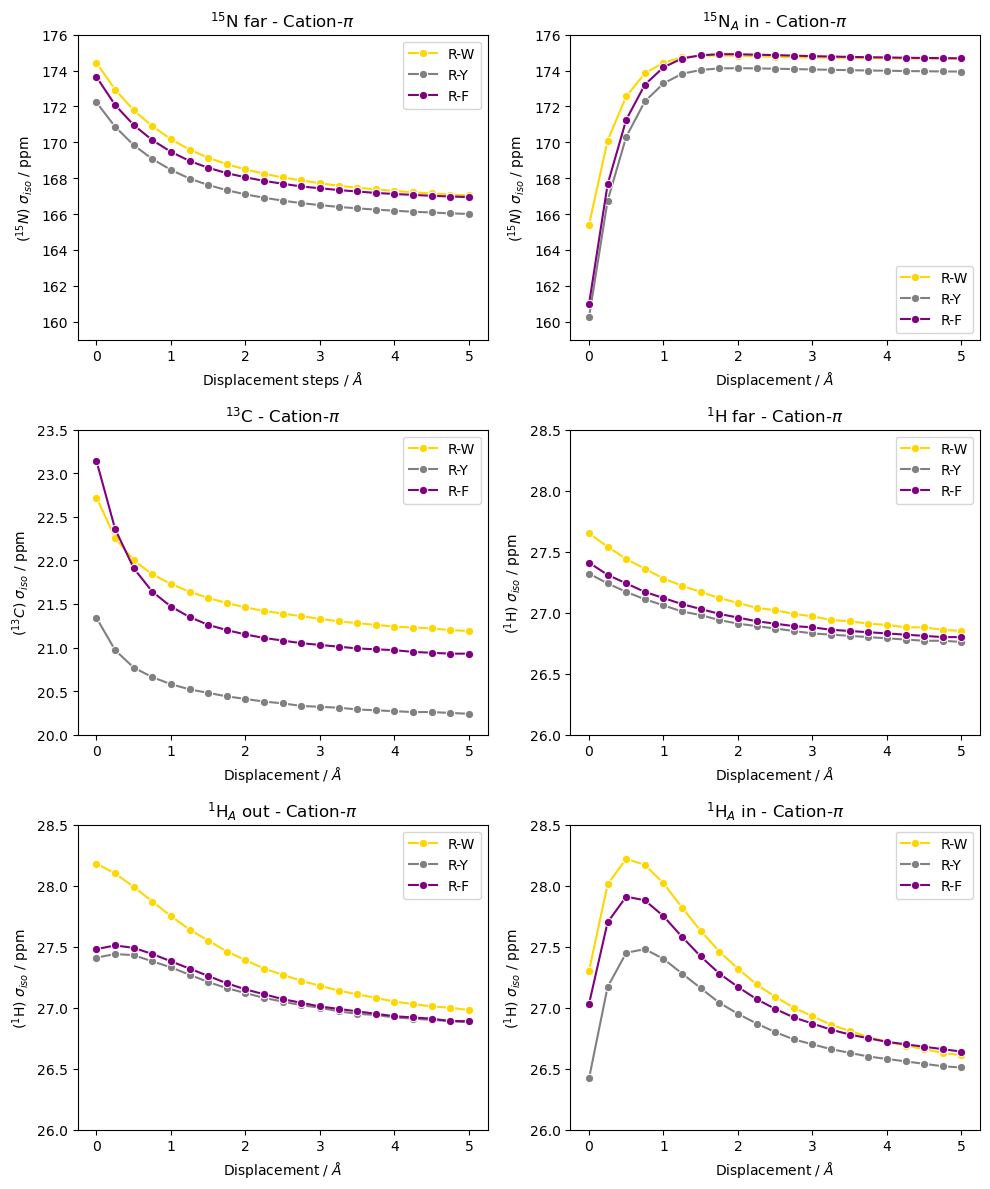

In [72]:
# Plot the effect of different aromatics on chemical shift 
# Cation-Pi interaction
# 15N far - 15NA
# 1H far - 1HA close
# 1HA out - 13C

fig, axes = plt.subplots(3, 2, figsize=(10, 12))

sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_15N_far, ax=axes[0, 0], marker='o', color="gold", 
             label="R-W", linestyle="-").set(title="$^{15}$N far - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{15}N$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_ry_15N_far, ax=axes[0, 0], marker='o', color="grey", 
             label="R-Y", linestyle="-").set(title="$^{15}$N far - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{15}N$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rf_15N_far, ax=axes[0, 0], marker='o', color="purple", 
             label="R-F", linestyle="-").set(title="$^{15}$N far - Cation-$\pi$", 
                                                 xlabel="Displacement steps / $\AA$", ylabel="($^{15}N$) $\sigma_{iso}$ / ppm", ylim=(159,176))

sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_15NA, ax=axes[0, 1], marker='o', color="gold", 
             label="R-W", linestyle="-").set(title="$^{15}$N$_A$ in - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{15}N$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_ry_15NA, ax=axes[0, 1], marker='o', color="grey", 
             label="R-Y", linestyle="-").set(title="$^{15}$N$_A$ in - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{15}N$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rf_15NA, ax=axes[0, 1], marker='o', color="purple", 
             label="R-F", linestyle="-").set(title="$^{15}$N$_A$ in - Cation-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{15}N$) $\sigma_{iso}$ / ppm", ylim=(159,176))

sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_13C, ax=axes[1, 0], marker='o', color="gold", 
             label="R-W", linestyle="-").set(title="$^{13}$C - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_ry_13C, ax=axes[1, 0], marker='o', color="grey", 
             label="R-Y", linestyle="-").set(title="$^{13}$C - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rf_13C, ax=axes[1, 0], marker='o', color="purple", 
             label="R-F", linestyle="-").set(title="$^{13}$C - Cation-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm", ylim=(20,23.5))

sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_1HA_close, ax=axes[2, 1], marker='o', color="gold", 
             label="R-W", linestyle="-").set(title="$^{1}$H$_A$ in - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_ry_1HA_close, ax=axes[2, 1], marker='o', color="grey", 
             label="R-Y", linestyle="-").set(title="$^{1}$H$_A$ in - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rf_1HA_close, ax=axes[2, 1], marker='o', color="purple", 
             label="R-F", linestyle="-").set(title="$^{1}$H$_A$ in - Cation-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm", ylim=(26,28.5))

sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_1HA_out, ax=axes[2, 0], marker='o', color="gold", 
             label="R-W", linestyle="-").set(title="$^{1}$H$_A$ out - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_ry_1HA_out, ax=axes[2, 0], marker='o', color="grey", 
             label="R-Y", linestyle="-").set(title="$^{1}$H$_A$ out - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rf_1HA_out, ax=axes[2, 0], marker='o', color="purple", 
             label="R-F", linestyle="-").set(title="$^{1}$H$_A$ out - Cation-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm", ylim=(26,28.5))

sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_1H_far, ax=axes[1, 1], marker='o', color="gold", 
             label="R-W", linestyle="-").set(title="$^{1}$H far - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_ry_1H_far, ax=axes[1, 1], marker='o', color="grey", 
             label="R-Y", linestyle="-").set(title="$^{1}$H far - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rf_1H_far, ax=axes[1, 1], marker='o', color="purple", 
             label="R-F", linestyle="-").set(title="$^{1}$H far - Cation-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm", ylim=(26,28.5))

plt.tight_layout()
plt.show()
#fig.savefig('Cation_pi_diff_arom.pdf', pad_inches=0.0)

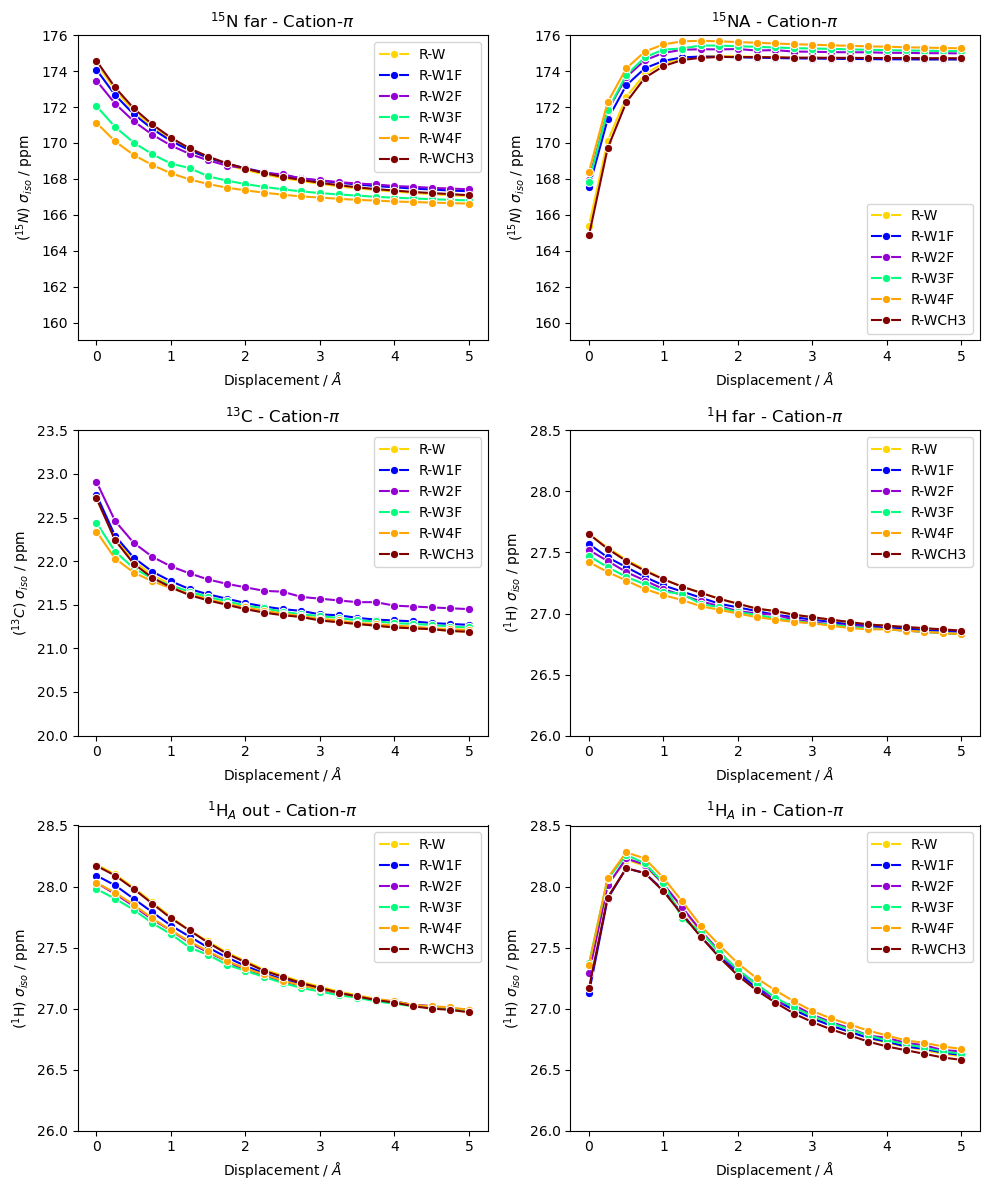

In [86]:
# Plot the effect of progressive on chemical shift 
# Cation-Pi interaction
# 15N far - 15NA
# 1H far - 1HA close
# 1HA out - 13C

fig, axes = plt.subplots(3, 2, figsize=(10, 12))

sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_15N_far, ax=axes[0, 0], marker='o', color="gold", 
             label="R-W", linestyle="-").set(title="$^{15}$N far - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{15}N$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_1f_15N_far, ax=axes[0, 0], marker='o', color="blue", 
             label="R-W1F", linestyle="-").set(title="$^{15}$N far - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{15}N$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_2f_15N_far, ax=axes[0, 0], marker='o', color="darkviolet", 
             label="R-W2F", linestyle="-").set(title="$^{15}$N far - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{15}N$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_3f_15N_far, ax=axes[0, 0], marker='o', color="springgreen", 
             label="R-W3F", linestyle="-").set(title="$^{15}$N far - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{15}N$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_4f_15N_far, ax=axes[0, 0], marker='o', color="orange", 
             label="R-W4F", linestyle="-").set(title="$^{15}$N far - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{15}N$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_ch3_15N_far, ax=axes[0, 0], marker='o', color="maroon", 
             label="R-WCH3", linestyle="-").set(title="$^{15}$N far - Cation-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{15}N$) $\sigma_{iso}$ / ppm", ylim=(159,176))

sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_15NA, ax=axes[0, 1], marker='o', color="gold", 
             label="R-W", linestyle="-").set(title="$^{15}$NA - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{15}N$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_1f_15NA, ax=axes[0, 1], marker='o', color="blue", 
             label="R-W1F", linestyle="-").set(title="$^{15}$NA - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{15}N$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_2f_15NA, ax=axes[0, 1], marker='o', color="darkviolet", 
             label="R-W2F", linestyle="-").set(title="$^{15}$NA - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{15}N$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_3f_15NA, ax=axes[0, 1], marker='o', color="springgreen", 
             label="R-W3F", linestyle="-").set(title="$^{15}$NA - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{15}N$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_4f_15NA, ax=axes[0, 1], marker='o', color="orange", 
             label="R-W4F", linestyle="-").set(title="$^{15}$NA - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{15}N$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_ch3_15NA, ax=axes[0, 1], marker='o', color="maroon", 
             label="R-WCH3", linestyle="-").set(title="$^{15}$NA - Cation-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{15}N$) $\sigma_{iso}$ / ppm", ylim=(159,176))

sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_13C, ax=axes[1, 0], marker='o', color="gold", 
             label="R-W", linestyle="-").set(title="$^{13}$C - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_1f_13C, ax=axes[1, 0], marker='o', color="blue", 
             label="R-W1F", linestyle="-").set(title="$^{13}$C - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_2f_13C, ax=axes[1, 0], marker='o', color="darkviolet", 
             label="R-W2F", linestyle="-").set(title="$^{13}$C - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_3f_13C, ax=axes[1, 0], marker='o', color="springgreen", 
             label="R-W3F", linestyle="-").set(title="$^{13}$C - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_4f_13C, ax=axes[1, 0], marker='o', color="orange", 
             label="R-W4F", linestyle="-").set(title="$^{13}$C - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_ch3_13C, ax=axes[1, 0], marker='o', color="maroon", 
             label="R-WCH3", linestyle="-").set(title="$^{13}$C - Cation-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm", ylim=(20,23.5))

sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_1HA_close, ax=axes[2, 1], marker='o', color="gold", 
             label="R-W", linestyle="-").set(title="$^{1}$H$_A$ in - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_1f_1HA_close, ax=axes[2, 1], marker='o', color="blue", 
             label="R-W1F", linestyle="-").set(title="$^{1}$H$_A$ in - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_2f_1HA_close, ax=axes[2, 1], marker='o', color="darkviolet", 
             label="R-W2F", linestyle="-").set(title="$^{1}$H$_A$ in - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_3f_1HA_close, ax=axes[2, 1], marker='o', color="springgreen", 
             label="R-W3F", linestyle="-").set(title="$^{1}$H$_A$ in - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_4f_1HA_close, ax=axes[2, 1], marker='o', color="orange", 
             label="R-W4F", linestyle="-").set(title="$^{1}$H$_A$ in - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_ch3_1HA_close, ax=axes[2, 1], marker='o', color="maroon", 
             label="R-WCH3", linestyle="-").set(title="$^{1}$H$_A$ in - Cation-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm", ylim=(26,28.5))


sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_1HA_out, ax=axes[2, 0], marker='o', color="gold", 
             label="R-W", linestyle="-").set(title="$^{1}$H$_A$ out - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_1f_1HA_out, ax=axes[2, 0], marker='o', color="blue", 
             label="R-W1F", linestyle="-").set(title="$^{1}$H$_A$ out - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_2f_1HA_out, ax=axes[2, 0], marker='o', color="darkviolet", 
             label="R-W2F", linestyle="-").set(title="$^{1}$H$_A$ out - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_3f_1HA_out, ax=axes[2, 0], marker='o', color="springgreen", 
             label="R-W3F", linestyle="-").set(title="$^{1}$H$_A$ out - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_4f_1HA_out, ax=axes[2, 0], marker='o', color="orange", 
             label="R-W4F", linestyle="-").set(title="$^{1}$H$_A$ out - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_ch3_1HA_out, ax=axes[2, 0], marker='o', color="maroon", 
             label="R-WCH3", linestyle="-").set(title="$^{1}$H$_A$ out - Cation-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm", ylim=(26,28.5))


sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_1H_far, ax=axes[1, 1], marker='o', color="gold", 
             label="R-W", linestyle="-").set(title="$^{1}$H far - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_1f_1H_far, ax=axes[1, 1], marker='o', color="blue", 
             label="R-W1F", linestyle="-").set(title="$^{1}$H far - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_2f_1H_far, ax=axes[1, 1], marker='o', color="darkviolet", 
             label="R-W2F", linestyle="-").set(title="$^{1}$H far - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_3f_1H_far, ax=axes[1, 1], marker='o', color="springgreen", 
             label="R-W3F", linestyle="-").set(title="$^{1}$H far - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_4f_1H_far, ax=axes[1, 1], marker='o', color="orange", 
             label="R-W4F", linestyle="-").set(title="$^{1}$H far - Cation-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_ch3_1H_far, ax=axes[1, 1], marker='o', color="maroon", 
             label="R-WCH3", linestyle="-").set(title="$^{1}$H far - Cation-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm", ylim=(26,28.5))

plt.tight_layout()
plt.show()
#fig.savefig('Cation_pi_W_fluor.pdf', pad_inches=0.0)

In [ ]:
# Plot the effect of different aromatics on chemical shift 
# Anion-Pi interaction
# 13C close - 13C far

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.lineplot(x=xdat,y='sigma_iso', data=df_dw_13C_close, ax=axes[0], marker='o', color="gold", 
             label="D-W", linestyle="-").set(title="$^{13}$C close - Anion-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_dy_13C_close, ax=axes[0], marker='o', color="grey", 
             label="D-Y", linestyle="-").set(title="$^{13}$C close - Anion-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_df_13C_close, ax=axes[0], marker='o', color="purple", 
             label="D-F", linestyle="-").set(title="$^{13}$C close - Anion-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")

sns.lineplot(x=xdat,y='sigma_iso', data=df_dw_13C_far, ax=axes[1], marker='o', color="gold", 
             label="D-W", linestyle="-").set(title="$^{13}$C far - Anion-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_dy_13C_far, ax=axes[1], marker='o', color="grey", 
             label="D-Y", linestyle="-").set(title="$^{13}$C far - Anion-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_df_13C_far, ax=axes[1], marker='o', color="purple", 
             label="D-F", linestyle="-").set(title="$^{13}$C far - Anion-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")

plt.tight_layout()
plt.show()
fig.savefig('Anion_pi_diff_arom.pdf', pad_inches=0.0)

In [ ]:
# Plot the effect of progressive fluorination on chemical shift 
# Anion-Pi interaction
# 13C close - 13C far

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.lineplot(x=xdat,y='sigma_iso', data=df_dw_13C_close, ax=axes[0], marker='o', color="gold", 
             label="D-W", linestyle="-").set(title="$^{13}$C close - Anion-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_dw_1f_13C_close, ax=axes[0], marker='o', color="blue", 
             label="D-W1F", linestyle="-").set(title="$^{13}$C close - Anion-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_dw_2f_13C_close, ax=axes[0], marker='o', color="darkviolet", 
             label="D-W2F", linestyle="-").set(title="$^{13}$C close - Anion-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_dw_3f_13C_close, ax=axes[0], marker='o', color="springgreen", 
             label="D-W3F", linestyle="-").set(title="$^{13}$C close - Anion-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_dw_4f_13C_close, ax=axes[0], marker='o', color="orange", 
             label="D-W4F", linestyle="-").set(title="$^{13}$C close - Anion-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_dw_ch3_13C_close, ax=axes[0], marker='o', color="maroon", 
             label="D-WCH3", linestyle="-").set(title="$^{13}$C close - Anion-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")

sns.lineplot(x=xdat,y='sigma_iso', data=df_dw_13C_far, ax=axes[1], marker='o', color="gold", 
             label="D-W", linestyle="-").set(title="$^{13}$C far - Anion-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_dw_1f_13C_far, ax=axes[1], marker='o', color="blue", 
             label="D-W1F", linestyle="-").set(title="$^{13}$C far - Anion-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_dw_2f_13C_far, ax=axes[1], marker='o', color="darkviolet", 
             label="D-W2F", linestyle="-").set(title="$^{13}$C far - Anion-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_dw_3f_13C_far, ax=axes[1], marker='o', color="springgreen", 
             label="D-W3F", linestyle="-").set(title="$^{13}$C far - Anion-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_dw_4f_13C_far, ax=axes[1], marker='o', color="orange", 
             label="D-W4F", linestyle="-").set(title="$^{13}$C far - Anion-$\pi$", 
                                                 xlabel="Displacement steps", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")
sns.lineplot(x=xdat,y='sigma_iso', data=df_dw_ch3_13C_far, ax=axes[1], marker='o', color="maroon", 
             label="D-WCH3", linestyle="-").set(title="$^{13}$C far - Anion-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")

plt.tight_layout()
plt.show()
fig.savefig('Anion_pi_W_fluor.pdf', pad_inches=0.0)

In [ ]:
# Plot the effect of one only aromatics on chemical shift 
# Cation-Pi interaction
# 15N far - 15NA
# 1H far - 1HA close
# 1HA out - 13C

fig, axes = plt.subplots(3, 2, figsize=(10, 12))


sns.lineplot(x=xdat,y='sigma_iso', data=df_rf_15N_far, ax=axes[0, 0], marker='o', color="grey", 
             label="R-F", linestyle="-").set(title="$^{15}$N far - Cation-$\pi$", 
                                                 xlabel="Displacement steps / $\AA$", ylabel="($^{15}N$) $\sigma_{iso}$ / ppm", ylim=(159,176))

sns.lineplot(x=xdat,y='sigma_iso', data=df_rf_15NA, ax=axes[0, 1], marker='o', color="grey", 
             label="R-F", linestyle="-").set(title="$^{15}$N$_A$ in - Cation-$\pi$", 
                                                 xlabel="Displacement steps / $\AA$", ylabel="($^{15}N$) $\sigma_{iso}$ / ppm", ylim=(159,176))

sns.lineplot(x=xdat,y='sigma_iso', data=df_rf_13C, ax=axes[1, 0], marker='o', color="grey", 
             label="R-F", linestyle="-").set(title="$^{13}$C - Cation-$\pi$", 
                                                 xlabel="Displacement steps / $\AA$", ylabel="($^{13}C$) $\sigma_{iso}$ / ppm")

sns.lineplot(x=xdat,y='sigma_iso', data=df_rf_1HA_close, ax=axes[2, 1], marker='o', color="grey", 
             label="R-F", linestyle="-").set(title="$^{1}$H$_A$ in - Cation-$\pi$", 
                                                 xlabel="Displacement steps / $\AA$", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm", ylim=(26.6,28))

sns.lineplot(x=xdat,y='sigma_iso', data=df_rf_1HA_out, ax=axes[2, 0], marker='o', color="grey", 
             label="R-F", linestyle="-").set(title="$^{1}$H$_A$ out - Cation-$\pi$", 
                                                 xlabel="Displacement steps / $\AA$", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm", ylim=(26.6,28))


sns.lineplot(x=xdat,y='sigma_iso', data=df_rf_1H_far, ax=axes[1, 1], marker='o', color="grey", 
             label="R-F", linestyle="-").set(title="$^{1}$H far - Cation-$\pi$", 
                                                 xlabel="Displacement steps / $\AA$", ylabel="($^{1}$H) $\sigma_{iso}$ / ppm", ylim=(26.6,28))


plt.tight_layout()
plt.show()
fig.savefig('Cation_pi_F_diff_arom.pdf', pad_inches=0.0)

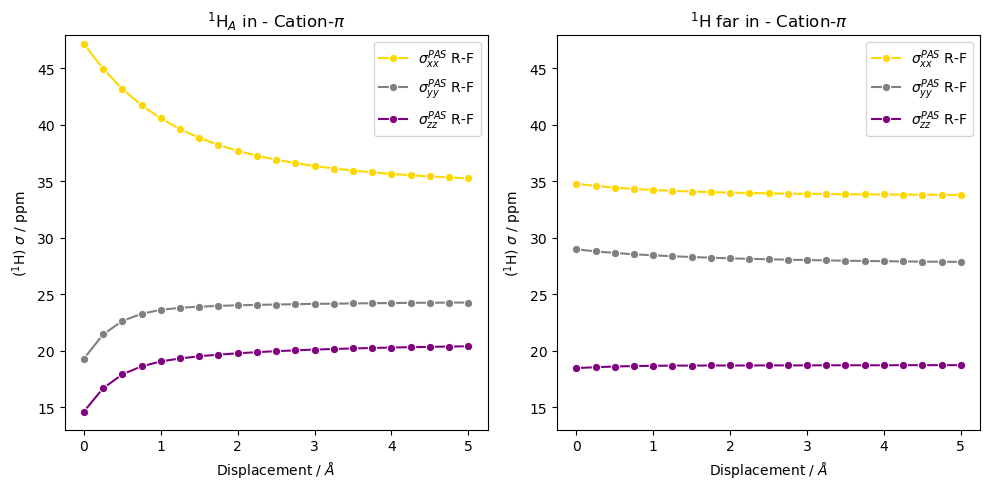

In [120]:
# Plot the effect of different aromatics on chemical shielding tensor
# Cation-Pi interaction
# 15N far - 15NA
# 1H far - 1HA close
# 1HA out - 13C

fig, axes = plt.subplots(1, 2, figsize=(10, 5))



sns.lineplot(x=xdat,y='sigma_xx', data=df_rf_1HA_close, ax=axes[0], marker='o', color="gold", 
             label="$\sigma^{PAS}_{xx}$ R-F", linestyle="-").set(title="$^{1}$H$_A$ in - Cation-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{1}$H) $\sigma$ / ppm")
sns.lineplot(x=xdat,y='sigma_yy', data=df_rf_1HA_close, ax=axes[0], marker='o', color="grey", 
             label="$\sigma^{PAS}_{yy}$ R-F", linestyle="-").set(title="$^{1}$H$_A$ in - Cation-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{1}$H) $\sigma$ / ppm")
sns.lineplot(x=xdat,y='sigma_zz', data=df_rf_1HA_close, ax=axes[0], marker='o', color="purple", 
             label="$\sigma^{PAS}_{zz}$ R-F", linestyle="-").set(title="$^{1}$H$_A$ in - Cation-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{1}$H) $\sigma$ / ppm",ylim=(13,48))


sns.lineplot(x=xdat,y='sigma_xx', data=df_rf_1H_far, ax=axes[1], marker='o', color="gold", 
             label="$\sigma^{PAS}_{xx}$ R-F", linestyle="-").set(title="$^{1}$H far in - Cation-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{1}$H) $\sigma$ / ppm")
sns.lineplot(x=xdat,y='sigma_yy', data=df_rf_1H_far, ax=axes[1], marker='o', color="grey", 
             label="$\sigma^{PAS}_{yy}$ R-F", linestyle="-").set(title="$^{1}$H far in - Cation-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{1}$H) $\sigma$ / ppm")
sns.lineplot(x=xdat,y='sigma_zz', data=df_rf_1H_far, ax=axes[1], marker='o', color="purple", 
             label="$\sigma^{PAS}_{zz}$ R-F", linestyle="-").set(title="$^{1}$H far in - Cation-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{1}$H) $\sigma$ / ppm",ylim=(13,48))


plt.tight_layout()
plt.show()
fig.savefig('Cation_pi_1H_tensor_components2.pdf', pad_inches=0.0)

In [ ]:
# Plot the effect of different aromatics on chemical shielding tensor
# Cation-Pi interaction
# 15N far - 15NA
# 1H far - 1HA close
# 1HA out - 13C

fig, axes = plt.subplots(1, 2, figsize=(10, 5))


sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_1HA_close, ax=axes[0], marker='o', color="black", 
             label="$\sigma_{iso}$ R-F", linestyle="-").set(title="$^{1}$H$_A$ in - Cation-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{1}$H) $\sigma$ / ppm")
sns.lineplot(x=xdat,y='para_sigma_xx', data=df_rf_1HA_close, ax=axes[0], marker='o', color="gold", 
             label="$\sigma^{PAS}_{xx}$ R-F", linestyle="-").set(title="$^{1}$H$_A$ in - Cation-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{1}$H) $\sigma$ / ppm")
sns.lineplot(x=xdat,y='para_sigma_yy', data=df_rf_1HA_close, ax=axes[0], marker='o', color="grey", 
             label="$\sigma^{PAS}_{yy}$ R-F", linestyle="-").set(title="$^{1}$H$_A$ in - Cation-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{1}$H) $\sigma$ / ppm")
sns.lineplot(x=xdat,y='para_sigma_zz', data=df_rf_1HA_close, ax=axes[0], marker='o', color="purple", 
             label="$\sigma^{PAS}_{zz}$ R-F", linestyle="-").set(title="$^{1}$H$_A$ in - Cation-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{1}$H) $\sigma$ / ppm")

sns.lineplot(x=xdat,y='sigma_iso', data=df_rw_1HA_close, ax=axes[1], marker='o', color="black", 
             label="$\sigma_{iso}$ R-F", linestyle="-").set(title="$^{1}$H$_A$ in - Cation-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{1}$H) $\sigma$ / ppm")
sns.lineplot(x=xdat,y='para_sigma_xx', data=df_rw_1HA_close, ax=axes[1], marker='o', color="gold", 
             label="$\sigma^{PAS}_{xx}$ R-F", linestyle="-").set(title="$^{1}$H$_A$ in - Cation-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{1}$H) $\sigma$ / ppm")
sns.lineplot(x=xdat,y='para_sigma_yy', data=df_rw_1HA_close, ax=axes[1], marker='o', color="grey", 
             label="$\sigma^{PAS}_{yy}$ R-F", linestyle="-").set(title="$^{1}$H$_A$ in - Cation-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{1}$H) $\sigma$ / ppm")
sns.lineplot(x=xdat,y='para_sigma_zz', data=df_rw_1HA_close, ax=axes[1], marker='o', color="purple", 
             label="$\sigma^{PAS}_{zz}$ R-F", linestyle="-").set(title="$^{1}$H$_A$ in - Cation-$\pi$", 
                                                 xlabel="Displacement / $\AA$", ylabel="($^{1}$H) $\sigma$ / ppm")



plt.tight_layout()
plt.show()
#fig.savefig('Cation_pi_1H_tensor_components.pdf', pad_inches=0.0)

# Unsupervised Learning 

Here we use algortithms to elucidate the structure of the training data. We cluster the data points in groups, and project them in two dimensions to understand their distribution.

In [ ]:
# The following figure shows us a table with scatter plots for each two pairs of features.
# The diagonal plots are the histograms for the variables

fig, ax = plt.subplots(figsize=[18,10])
caxes = pd.plotting.scatter_matrix(nucprop_df, ax=ax)
plt.show()

In [ ]:
# clustering algorithm
from sklearn.cluster import KMeans

# linear dimensionality analysis
from sklearn.decomposition import PCA

# nonlinear dimensionality analysis
from sklearn.manifold import TSNE

In [ ]:
# Unsupervised learning methods are sensistive to the mean value and the variance of each feature. 
# Here we normalize the data so all the features have zero mean and equal variance
real_nucprop_df = nucprop_df.applymap(lambda x: np.real(x))
normalized_nucprop_df = (real_nucprop_df - real_nucprop_df.mean()) / real_nucprop_df.std()

### K-Means Clustering
Here we cluster the data points into groups. The most straighforward method to do so is K-means. K-means cluster the points in K groups by finding K centers of mass of the data. It separates the space with linear boundaries. 

The "Elbow curve" is a tool that helps to define the suitable number of clusters. When the decrease of the curve slows down it means more clusters are unnecessary. However, the stopping criteria is arbitrary.

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # 'median', 'most_frequent', or 'constant'

# Fill NaN values
nonan_db = imputer.fit_transform(normalized_nucprop_df)
 
k_ellbow = []
for E in range(1,15):
    kmeans = KMeans(n_clusters=E)
    kmeans.fit(nonan_db)
    score = kmeans.score(nonan_db)
    k_ellbow.append(score)

In [ ]:
plt.figure(figsize=(12,9))
plt.title('Elbow curve')
plt.xlabel('n cluster')
plt.ylabel('grad Score')
plt.plot([3,3],[0,np.max(np.gradient(k_ellbow))])
plt.xticks(np.arange(1, len(k_ellbow) + 1))
plt.plot(range(1, len(k_ellbow) + 1), np.gradient(k_ellbow), 'k');

In [ ]:
## Elbow curve shows significant drop when more than 2 clusters are used.
## Minimum number of cluster for analysis is therefore 3.
##Lets use K-Means Cluster prediction for 3 clusters:
cluster = KMeans(n_clusters=5)
cluster.fit(nonan_db)
cluster_predictions = cluster.predict(nonan_db)

In [ ]:
# We can plot the same scatter plots and color the points with the cluster labels.

fig, ax = plt.subplots(figsize=[18,10])
caxes = pd.plotting.scatter_matrix(real_nucprop_df, c=cluster_predictions, ax=ax, cmap=plt.cm.get_cmap('rainbow',5), 
    vmin=-0.5, vmax=2.5)
im = caxes[0,1].collections[0]
cbar = fig.colorbar(im, ax=caxes, ticks=range(4), label='Cluster label')

plt.show()

### Dimensionality Reduction of the Data with Principal Component Analysis.

Two ways to reduce the data dimensionality:

* PCA pojects the data in two (or more) vectors constructed as linear combinations of the original vectors. The vectors chosed are the ones that "capture the most variance", the ones that represent the most relevant directions in the data (in a linear sense)

* TSNE is a family of techniques called manifold learning (https://scikit-learn.org/stable/modules/manifold.html) . It constructs a graph by connecting each point with its neighbours, which is then disentangueled and projected in a lower dimensional space.


In [ ]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(nonan_db)

In [ ]:
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(nonan_db)

In [ ]:
# Compare their 2D projections
fig, axs = plt.subplots(1,2,figsize=(15,9))
axs[0].set_title('Principal Components')
axs[1].set_title('t-SNE')
for cluster in np.unique(cluster_predictions):
    plot1 = axs[0].scatter(pca_data[cluster_predictions == cluster,0], pca_data[cluster_predictions == cluster,1], label='Cluster {}'.format(cluster))
    plot2 = axs[1].scatter(tsne_data[cluster_predictions == cluster,0], tsne_data[cluster_predictions == cluster,1], label='Cluster {}'.format(cluster))
axs[0].legend()
axs[1].legend()
#fig.colorbar(plot2, ax=axs);

# Plotting $\Delta\sigma$

In [50]:
############################################################################################
# reference values for dissociation limit, i.e. isotropic shieldings from isolated gas phase fragments
hp_pi_15N_nuc_ref = 144.76

hp_pi_1HA_nuc_ref = 26.45

hp_pi_1HB_nuc_ref = 26.81

hp_pi_13C_nuc_ref = 6.58
#-------------------------------------------------------------------------------------------------------
cation_pi_R_13C_nuc_ref = 20.81

cation_pi_R_1HA_close_nuc_ref = 26.66

cation_pi_R_1HA_out_nuc_ref = 26.76

cation_pi_R_1HB_close_nuc_ref = 26.43

cation_pi_R_1HB_out_nuc_ref = 26.44

cation_pi_R_1H_far_nuc_ref = 26.66

cation_pi_R_15N_far_nuc_ref = 164.63

cation_pi_R_15NA_nuc_ref = 175.71

cation_pi_R_15NB_nuc_ref = 175.14

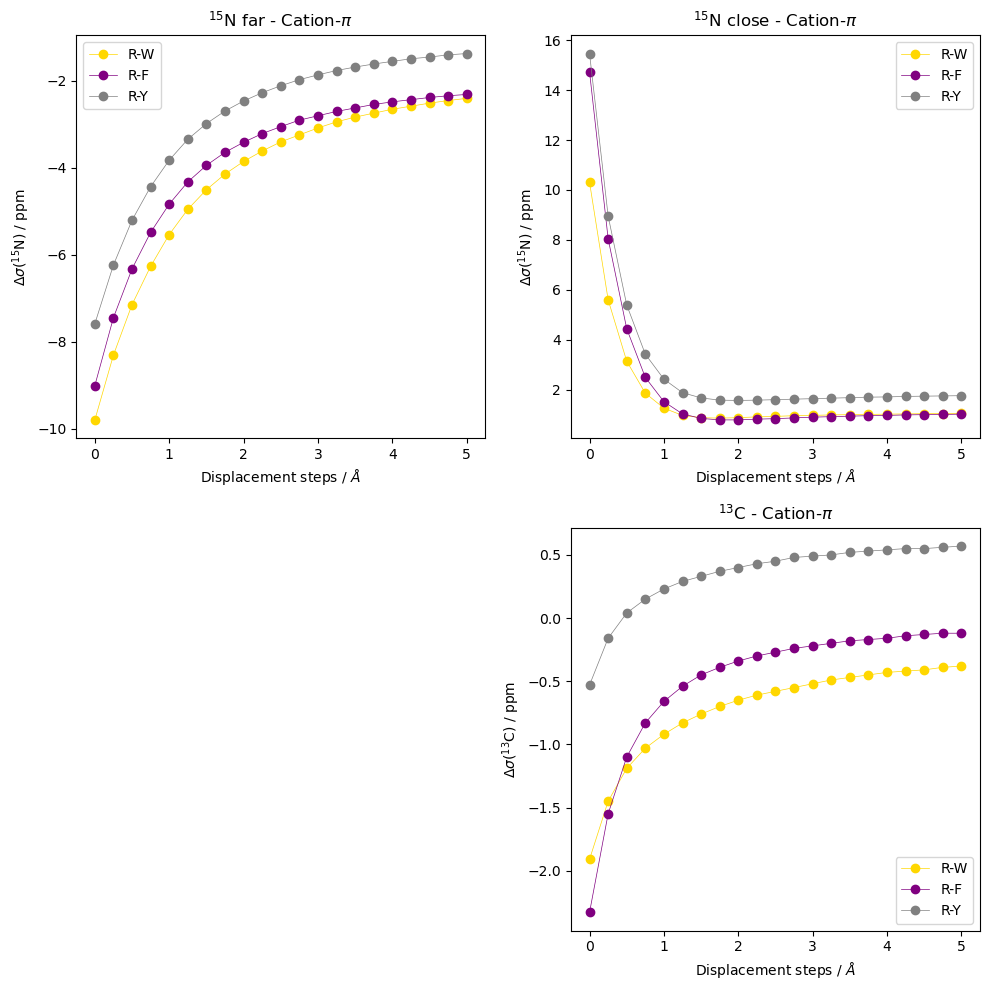

In [110]:
# Plot the effect of different aromatics on delta-sigma
# Cation-Pi interaction
# 15N far - 15NA
# 1H far - 1HA close
# 1HA out - 13C

fig = plt.figure(figsize=(10, 10))

#-------------------------------------------------------------------------------------------------------
plt.subplot(2, 2, 1) 
plt.plot(xdat,cation_pi_R_15N_far_nuc_ref-df_rw_15N_far['sigma_iso'], '-o', color='gold', label='R-W', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{15}$N) / ppm')
plt.title("$^{15}$N far - Cation-$\pi$")
plt.legend()

plt.subplot(2, 2, 1) 
plt.plot(xdat,cation_pi_R_15N_far_nuc_ref-df_rf_15N_far['sigma_iso'], '-o', color='purple', label='R-F', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{15}$N) / ppm')
plt.title("$^{15}$N far - Cation-$\pi$")
plt.legend()

plt.subplot(2, 2, 1) 
plt.plot(xdat,cation_pi_R_15N_far_nuc_ref-df_ry_15N_far['sigma_iso'], '-o', color='grey', label='R-Y', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{15}$N) / ppm')
plt.title("$^{15}$N far - Cation-$\pi$")
plt.legend()
#-------------------------------------------------------------------------------------------------------

plt.subplot(2, 2, 2) 
plt.plot(xdat,cation_pi_R_15NA_nuc_ref-df_rw_15NA['sigma_iso'], '-o', color='gold', label='R-W', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{15}$N) / ppm')
plt.title("$^{15}$N close - Cation-$\pi$")
plt.legend()

plt.subplot(2, 2, 2) 
plt.plot(xdat,cation_pi_R_15NA_nuc_ref-df_rf_15NA['sigma_iso'], '-o', color='purple', label='R-F', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{15}$N) / ppm')
plt.title("$^{15}$N close - Cation-$\pi$")
plt.legend()

plt.subplot(2, 2, 2) 
plt.plot(xdat,cation_pi_R_15NA_nuc_ref-df_ry_15NA['sigma_iso'], '-o', color='grey', label='R-Y', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{15}$N) / ppm')
plt.title("$^{15}$N close - Cation-$\pi$")
plt.legend()
#-------------------------------------------------------------------------------------------------------

plt.subplot(2, 2, 4) 
plt.plot(xdat,cation_pi_R_13C_nuc_ref-df_rw_13C['sigma_iso'], '-o', color='gold', label='R-W', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{13}$C) / ppm')
plt.title("$^{13}$C - Cation-$\pi$")
plt.legend()

plt.subplot(2, 2, 4) 
plt.plot(xdat,cation_pi_R_13C_nuc_ref-df_rf_13C['sigma_iso'], '-o', color='purple', label='R-F', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{13}$C) / ppm')
plt.title("$^{13}$C - Cation-$\pi$")
plt.legend()

plt.subplot(2, 2, 4) 
plt.plot(xdat,cation_pi_R_13C_nuc_ref-df_ry_13C['sigma_iso'], '-o', color='grey', label='R-Y', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{13}$C) / ppm')
plt.title("$^{13}$C - Cation-$\pi$")
plt.legend()
#-------------------------------------------------------------------------------------------------------

plt.tight_layout()
plt.show()

fig.savefig('Cation_pi_Ds_15N_13C.pdf', pad_inches=0.0)

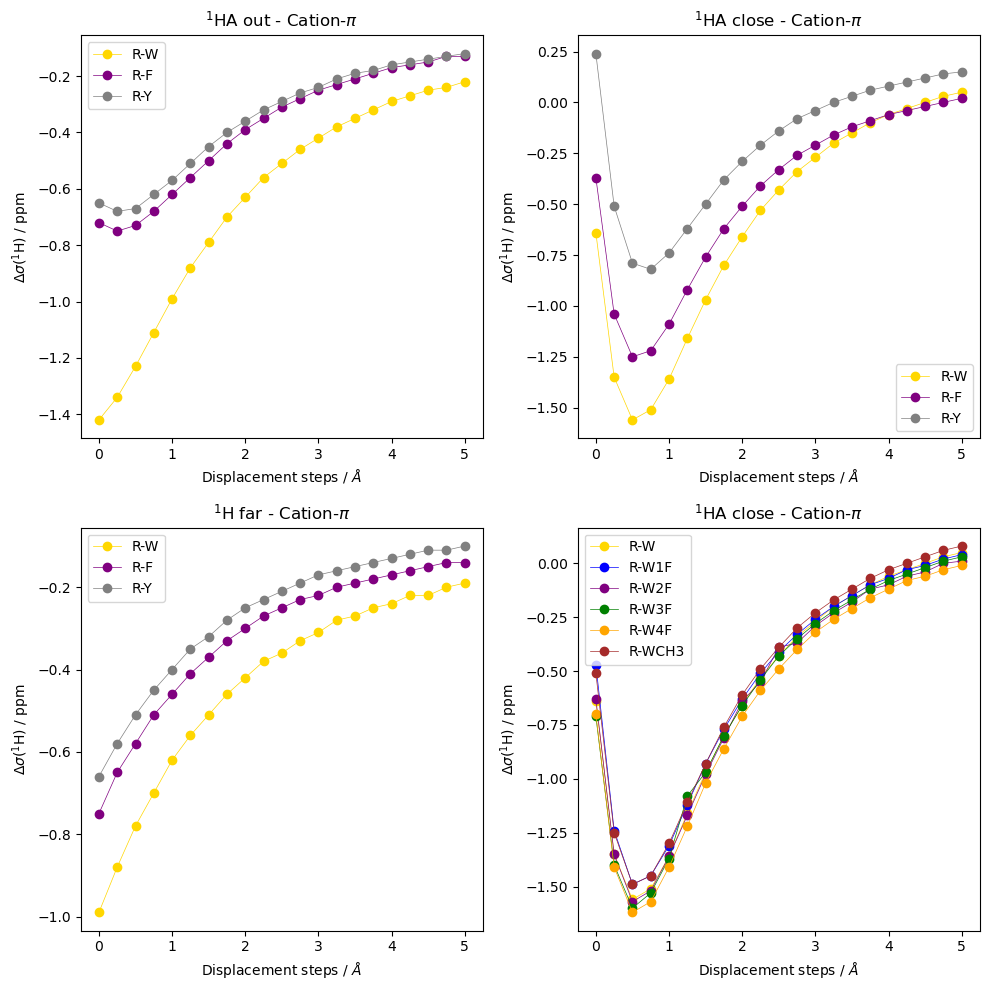

In [112]:
# Plot the effect of different aromatics on delta-sigma
# Cation-Pi interaction
# 15N far - 15NA
# 1H far - 1HA close
# 1HA out - 13C

fig = plt.figure(figsize=(10, 10))

#-------------------------------------------------------------------------------------------------------
plt.subplot(2, 2, 1) 
plt.plot(xdat,cation_pi_R_1HA_out_nuc_ref-df_rw_1HA_out['sigma_iso'], '-o', color='gold', label='R-W', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{1}$H) / ppm')
plt.title("$^{1}$HA out - Cation-$\pi$")
plt.legend()

plt.subplot(2, 2, 1) 
plt.plot(xdat,cation_pi_R_1HA_out_nuc_ref-df_rf_1HA_out['sigma_iso'], '-o', color='purple', label='R-F', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{1}$H) / ppm')
plt.title("$^{1}$HA out - Cation-$\pi$")
plt.legend()

plt.subplot(2, 2, 1) 
plt.plot(xdat,cation_pi_R_1HA_out_nuc_ref-df_ry_1HA_out['sigma_iso'], '-o', color='grey', label='R-Y', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{1}$H) / ppm')
plt.title("$^{1}$HA out - Cation-$\pi$")
plt.legend()
#-------------------------------------------------------------------------------------------------------

plt.subplot(2, 2, 2) 
plt.plot(xdat,cation_pi_R_1HA_close_nuc_ref-df_rw_1HA_close['sigma_iso'], '-o', color='gold', label='R-W', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{1}$H) / ppm')
plt.title("$^{1}$HA close - Cation-$\pi$")
plt.legend()

plt.subplot(2, 2, 2) 
plt.plot(xdat,cation_pi_R_1HA_close_nuc_ref-df_rf_1HA_close['sigma_iso'], '-o', color='purple', label='R-F', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{1}$H) / ppm')
plt.title("$^{1}$HA close - Cation-$\pi$")
plt.legend()

plt.subplot(2, 2, 2) 
plt.plot(xdat,cation_pi_R_1HA_close_nuc_ref-df_ry_1HA_close['sigma_iso'], '-o', color='grey', label='R-Y', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{1}$H) / ppm')
plt.title("$^{1}$HA close - Cation-$\pi$")
plt.legend()
#-------------------------------------------------------------------------------------------------------

plt.subplot(2, 2, 3) 
plt.plot(xdat,cation_pi_R_1H_far_nuc_ref-df_rw_1H_far['sigma_iso'], '-o', color='gold', label='R-W', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{1}$H) / ppm')
plt.title("$^{1}$H far - Cation-$\pi$")
plt.legend()

plt.subplot(2, 2, 3) 
plt.plot(xdat,cation_pi_R_1H_far_nuc_ref-df_rf_1H_far['sigma_iso'], '-o', color='purple', label='R-F', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{1}$H) / ppm')
plt.title("$^{1}$H far - Cation-$\pi$")
plt.legend()

plt.subplot(2, 2, 3) 
plt.plot(xdat,cation_pi_R_1H_far_nuc_ref-df_ry_1H_far['sigma_iso'], '-o', color='grey', label='R-Y', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{1}$H) / ppm')
plt.title("$^{1}$H far - Cation-$\pi$")
plt.legend()
#-------------------------------------------------------------------------------------------------------

plt.subplot(2, 2, 4) 
plt.plot(xdat,cation_pi_R_1HA_close_nuc_ref-df_rw_1HA_close['sigma_iso'], '-o', color='gold', label='R-W', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{1}$H) / ppm')
plt.title("$^{1}$HA close - Cation-$\pi$")
plt.legend()

plt.subplot(2, 2, 4) 
plt.plot(xdat,cation_pi_R_1HA_close_nuc_ref-df_rw_1f_1HA_close['sigma_iso'], '-o', color='blue', label='R-W1F', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{1}$H) / ppm')
plt.title("$^{1}$HA close - Cation-$\pi$")
plt.legend()

plt.subplot(2, 2, 4) 
plt.plot(xdat,cation_pi_R_1HA_close_nuc_ref-df_rw_2f_1HA_close['sigma_iso'], '-o', color='purple', label='R-W2F', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{1}$H) / ppm')
plt.title("$^{1}$HA close - Cation-$\pi$")
plt.legend()

plt.subplot(2, 2, 4) 
plt.plot(xdat,cation_pi_R_1HA_close_nuc_ref-df_rw_3f_1HA_close['sigma_iso'], '-o', color='green', label='R-W3F', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{1}$H) / ppm')
plt.title("$^{1}$HA close - Cation-$\pi$")
plt.legend()

plt.subplot(2, 2, 4) 
plt.plot(xdat,cation_pi_R_1HA_close_nuc_ref-df_rw_4f_1HA_close['sigma_iso'], '-o', color='orange', label='R-W4F', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{1}$H) / ppm')
plt.title("$^{1}$HA close - Cation-$\pi$")
plt.legend()

plt.subplot(2, 2, 4) 
plt.plot(xdat,cation_pi_R_1HA_close_nuc_ref-df_rw_ch3_1HA_close['sigma_iso'], '-o', color='brown', label='R-WCH3', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{1}$H) / ppm')
plt.title("$^{1}$HA close - Cation-$\pi$")
plt.legend()

#-------------------------------------------------------------------------------------------------------

plt.tight_layout()
plt.show()

fig.savefig('Cation_pi_1H_Ds.pdf', pad_inches=0.0)

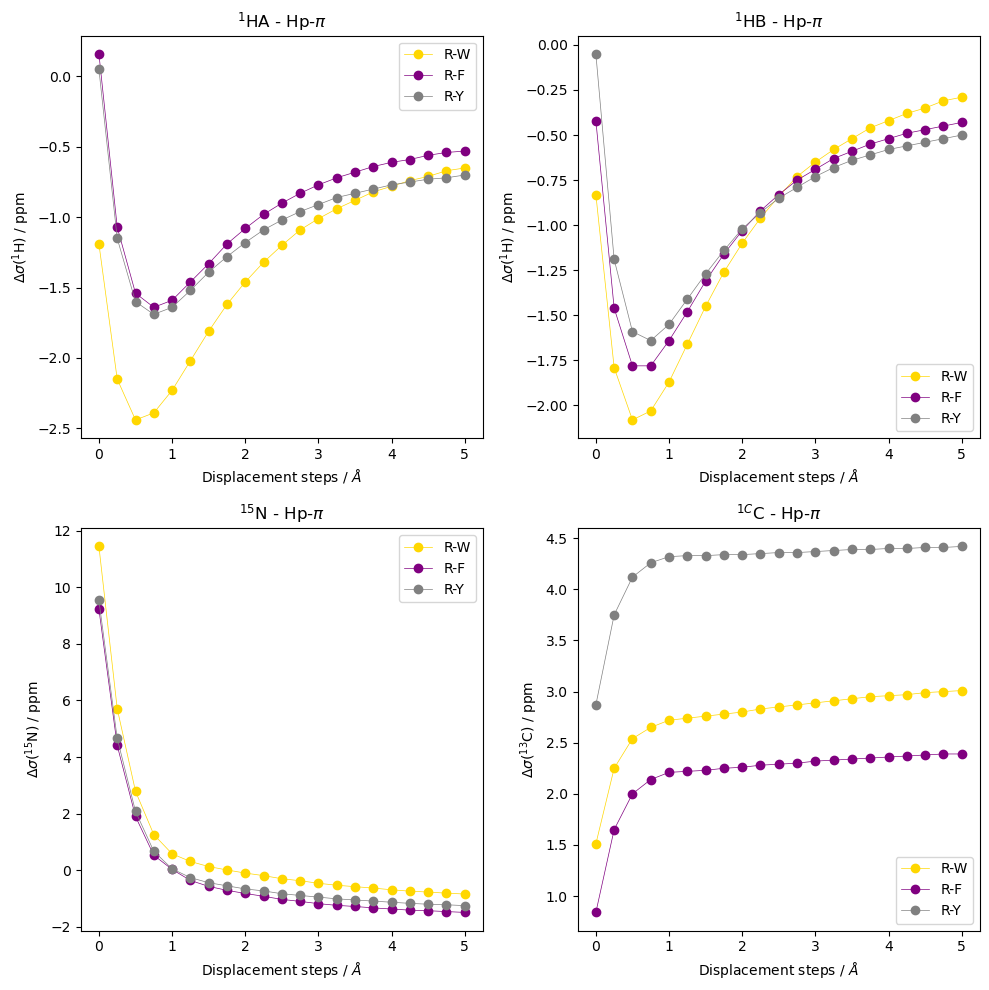

In [114]:
# Plot the effect of different aromatics on delta-sigma
# Cation-Pi interaction
# 15N far - 15NA
# 1H far - 1HA close
# 1HA out - 13C

fig = plt.figure(figsize=(10, 10))

#-------------------------------------------------------------------------------------------------------
plt.subplot(2, 2, 1) 
plt.plot(xdat,hp_pi_1HA_nuc_ref-df_nw_1HA['sigma_iso'], '-o', color='gold', label='R-W', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{1}$H) / ppm')
plt.title("$^{1}$HA - Hp-$\pi$")
plt.legend()

plt.subplot(2, 2, 1) 
plt.plot(xdat,hp_pi_1HA_nuc_ref-df_nf_1HA['sigma_iso'], '-o', color='purple', label='R-F', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{1}$H) / ppm')
plt.title("$^{1}$HA - Hp-$\pi$")
plt.legend()

plt.subplot(2, 2, 1) 
plt.plot(xdat,hp_pi_1HA_nuc_ref-df_ny_1HA['sigma_iso'], '-o', color='grey', label='R-Y', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{1}$H) / ppm')
plt.title("$^{1}$HA - Hp-$\pi$")
plt.legend()
#-------------------------------------------------------------------------------------------------------

plt.subplot(2, 2, 2) 
plt.plot(xdat,hp_pi_1HB_nuc_ref-df_nw_1HA['sigma_iso'], '-o', color='gold', label='R-W', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{1}$H) / ppm')
plt.title("$^{1}$HB - Hp-$\pi$")
plt.legend()

plt.subplot(2, 2, 2) 
plt.plot(xdat,hp_pi_1HB_nuc_ref-df_nf_1HB['sigma_iso'], '-o', color='purple', label='R-F', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{1}$H) / ppm')
plt.title("$^{1}$HB - Hp-$\pi$")
plt.legend()

plt.subplot(2, 2, 2) 
plt.plot(xdat,hp_pi_1HB_nuc_ref-df_ny_1HB['sigma_iso'], '-o', color='grey', label='R-Y', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{1}$H) / ppm')
plt.title("$^{1}$HB - Hp-$\pi$")
plt.legend()
#-------------------------------------------------------------------------------------------------------

plt.subplot(2, 2, 3) 
plt.plot(xdat,hp_pi_15N_nuc_ref-df_nw_15N['sigma_iso'], '-o', color='gold', label='R-W', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{15}$N) / ppm')
plt.title("$^{15}$N - Hp-$\pi$")
plt.legend()

plt.subplot(2, 2, 3) 
plt.plot(xdat,hp_pi_15N_nuc_ref-df_nf_15N['sigma_iso'], '-o', color='purple', label='R-F', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{15}$N) / ppm')
plt.title("$^{15}$N - Hp-$\pi$")
plt.legend()

plt.subplot(2, 2, 3) 
plt.plot(xdat,hp_pi_15N_nuc_ref-df_ny_15N['sigma_iso'], '-o', color='grey', label='R-Y', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{15}$N) / ppm')
plt.title("$^{15}$N - Hp-$\pi$")
plt.legend()
#-------------------------------------------------------------------------------------------------------

plt.subplot(2, 2, 4) 
plt.plot(xdat,hp_pi_13C_nuc_ref-df_nw_13C['sigma_iso'], '-o', color='gold', label='R-W', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{13}$C) / ppm')
plt.title("$^{1C}$C - Hp-$\pi$")
plt.legend()

plt.subplot(2, 2, 4) 
plt.plot(xdat,hp_pi_13C_nuc_ref-df_nf_13C['sigma_iso'], '-o', color='purple', label='R-F', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{13}$C) / ppm')
plt.title("$^{1C}$C - Hp-$\pi$")
plt.legend()

plt.subplot(2, 2, 4) 
plt.plot(xdat,hp_pi_13C_nuc_ref-df_ny_13C['sigma_iso'], '-o', color='grey', label='R-Y', linewidth=0.5)
plt.xlabel('Displacement steps / $\AA$')
plt.ylabel('$\Delta\sigma$($^{13}$C) / ppm')
plt.title("$^{1C}$C - Hp-$\pi$")
plt.legend()
#-------------------------------------------------------------------------------------------------------

plt.tight_layout()
plt.show()

fig.savefig('H_pi_all_nuclei_Ds.pdf', pad_inches=0.0)

In [ ]:
# --- Extract the spin-spin coupling tensor components for each pair of nuclei at each distance iteration --- #

# Initialize variables for tensor components
r_AB = []
ssDSO = []
ssPSO = []
ssFC = []
ssSD = []

# Extract NMR data from each splitted file
for job_number in range (1, n_jobs+1):
    
    orca_splitted_output = OrcaAnalysis().convert_path(os.path.join(scratch_dir, 'OrcaAnalysis/split_orca_output/benzene_H2O_relaxH', f'splitted_orca_job{job_number}.out'))
    
    r_ab, ssdso, sspso, ssfc, sssd = OrcaAnalysis().extract_spin_spin_couplings(orca_splitted_output)
    
    r_AB.append(r_ab)
    ssDSO.append(ssdso)
    ssPSO.append(sspso)
    ssFC.append(ssfc)
    ssSD.append(sssd)

In [ ]:
# --- Application example 2) J Coupling Tensor --- #

# Initialize an empty list to collect data
datapw = []


# Loop through the number of jobs and process each molecule
for job_number in range(n_jobs):
    molecule_name = list_molecules[job_number]
    
    # Extract the distance dictionary for the current job
    distance_dic = r_AB[job_number]
    
    # Check if the distance dictionary is valid
    if isinstance(distance_dic, dict):
        # Loop through each pair and its distance
        for (atom1, atom2), distance in distance_dic.items():
            # Create a row of data for this pair
            row_datapw = {
                'Molecule': molecule_name,
                'Atom_1': atom1,
                'Atom_2': atom2,
                'r_12': distance,
                'x_coord_1' : None, 
                'y_coord_1' : None, 
                'z_coord_1' : None, 
                'x_coord_2' : None, 
                'y_coord_2' : None, 
                'z_coord_2' : None,
                'J_iso' : None,
                'J_FC_11' : None,
                'J_FC_22' : None,
                'J_FC_33' : None,
                'J_DSO_11' : None,
                'J_DSO_22' : None,
                'J_DSO_33' : None,
                'J_PSO_11' : None,
                'J_PSO_22' : None,
                'J_PSO_33' : None,
                'J_SD_11' : None,
                'J_SD_22' : None,
                'J_SD_33' : None,
                'Mayer_BO' : None
            }
            # Append the row to the list
            datapw.append(row_datapw)

    m_bo_dict = mayer_bo[job_number]
        
    if isinstance(m_bo_dict, dict):
        for atom1, pairs in m_bo_dict.items():
            for atom2, bond_order in pairs:
                # Create a row of data for Mayer BO
                row_datapw = {
                    'Mayer_BO': bond_order
                }
                # Append the row to the Mayer BO list
                datapw.append(row_mayer_bo)

# Convert the list of rows to a DataFrame
datadf = pd.DataFrame(datapw)

# Load the existing DataFrame if needed (make sure to define `nucprop_df` earlier)
# Example: nucprop_df = pd.read_csv('existing_data.csv')

# Concatenate with the existing DataFrame
pw_nucprop_df2 = pd.concat([pw_nucprop_df, datadf], ignore_index=True)

# Save the updated DataFrame to a CSV file
#w_nucprop_df.to_csv('updated_nuclear_pairs.csv', index=False)

# Display the updated DataFrame
pw_nucprop_df2

## Visualize output with @MolView

Here is a collection of functions to visualize the shielding tensors values for selected nuclei

In [ ]:
# molecule = 'D:/PhD/Data/DFT/NONCOV/DFT_simulations/codes/scratch/test_structs/benzene_H2O.xyz'
molecule = 'C:/Users/ettor/Desktop/NONCOV/scratch/test_structs/benzene_H2O.xyz'

MolView().plot_3d_molecule(molecule)

In [ ]:
# Plot euler angles and rotated tensor
tensor_pas = np.diag([34.44, 26.2, 25.5])

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Define the ellipsoid parameters
a = tensor_pas[0][0]  # Semi-major axis - x
b = tensor_pas[1][1]   # Semi-minor axis - y
c = tensor_pas[2][2]   # Semi-minor axis - z

# Create a mesh grid
theta = np.linspace(0, np.pi, 50)          # Polar angle
phi = np.linspace(0, 2 * np.pi, 100)   # Azimuthal angle
Theta, Phi = np.meshgrid(theta, phi)

# Calculate the coordinates of points on the ellipsoid surface
X = a * np.sin(Theta) * np.cos(Phi)
Y = b * np.sin(Theta) * np.sin(Phi)
Z = c * np.cos(Theta)

# Create a 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.axes.set_xlim(-a-1, a+1)
ax.axes.set_ylim(-b-1, b+1)
ax.set_title('Ellipsoid Surface Plot')

plt.show()


## Postprocess NMR tensors with @NMRFunctions

Perform all the necessary calculations to e.g. transform a shielding tensor from the molecular frame to the PAS and order eigenvalues following either Mehring or Haberlen conventions based on user choices.

In [ ]:
# Tensor to Euler angles
mode = 'AZYZ'
order = 'Ascending'
alpha, beta, gamma, tensor_pas = NMRFunctions().tensor_to_euler(shielding_tensor, eigenvals, eigenvecs, symmetry, mode, order)

In [ ]:
# Generate equivalent sets of angles
NMRFunctions().EqEulerSet(alpha,beta,gamma)

## Modules: MolecularGraph

In [ ]:
fragment1 =(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)
fragment2 = (13, 14, 15)

mol_graph = MolecularGraph()

# Parse the XYZ file
atom_types, coordinates = mol_graph.parse_xyz(mol_dir)

# Calculate pairwise distances
distances = mol_graph.calculate_distances(coordinates)

# Detect covalent bonds
covalent_bonds = mol_graph.detect_bonds(atom_types, distances)

# Detect non-covalent interactions
noncovalent_interactions = mol_graph.detect_noncovalent_interactions(atom_types, distances)

# Build the molecular graph
#mol_graph = mol_graph.build_molecular_graph(atom_types, coordinates, covalent_bonds, noncovalent_interactions)

# Visualize the molecular graph
#mol_graph.draw()

# Plots 
mol_graph.plot_bond_dist_matrix(covalent_bonds, distances, atom_types)
mol_graph.plot_noncov_distance_map(noncovalent_interactions, atom_types)

# Build different graphs
covalent_bonds_graph = mol_graph.build_covalent_bonds_graph(atom_types, coordinates, covalent_bonds)
intramolecular_graph = mol_graph.build_intramolecular_graph(atom_types, coordinates, covalent_bonds, noncovalent_interactions)
intermolecular_graph = mol_graph.build_intermolecular_graph(atom_types, coordinates, noncovalent_interactions)

# Draw subplots while preserving atom positions
mol_graph.draw_subplots(covalent_bonds_graph, intramolecular_graph, intermolecular_graph, coordinates)


threshold = 1.6